# Io Line Fitting in the Eclipse

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm
from collections import OrderedDict
plt.rcParams.update({'figure.max_open_warning': 0})

In [150]:
"""Function that describes a Gaussian with parameters mu, sigma, and amplitude"""
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

"""Given a species string, spits out an array with all wavelengths in that species and a dataframe with wavelength
mu, sigma, amplitude, oscillator strength, and other notes"""
def target_array(line):
    array = pd.read_csv('../data/eclipse_guess.csv')
    target_mask = array.Species.str.endswith(line) #probably a better function but idk it right now
    array_line = array[target_mask]
    guess = array_line.to_numpy()

    C = np.delete(guess, 1, 1) #deleting columns from .csv file that are not wavelength, sigma, and amp
    C = np.delete(C, 1, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)
    test = np.delete(C, 3, 1)

    df_test = pd.DataFrame(test, columns = ['Wavelength','Sigma','Amplitude'])
    df_test = df_test.dropna() #removing all wavelengths that do not have initial guessing parameters
    test = df_test.to_numpy()
    return test, array_line

"""Given the test array, will spit out Gaussian fittings for each wavelength and plots the fit"""
def fit_whole_spectra(array):
    params = np.zeros((len(test),3))
    for index in tqdm(range(0, len(array))):
        guess1 = test[index] #takes initial guess from test array
        optim = optimize.least_squares(errfunc1, guess1, args=(wl, flux),
                               bounds=([guess1[0]-0.05, 0, 0],[guess1[0]+0.05, guess1[1]+0.1, guess1[2]+5]))
        #checks if parameters fit into bounds assigned and created optimized fit
        params[index] = optim['x'] #new array that holds all fitted parameters
        
        plt.figure(figsize=(16, 5))
        plt.title('COS Io Spectrum: {} {}'.format(line, guess1[0]))
        plt.plot(wl, flux,'g.', label='measurement')
        plt.plot(wl, gaussian(wl, *params[index]),
            lw=2, c='red', ls='--', label='bounded fit')
        plt.ylim(-1,guess1[2]+100)
        plt.xlim(guess1[0]-3,guess1[0]+3)
        plt.legend(loc='best')
    return params

"""Plots the amplitude of lines versus the oscillator strength with linear line of best fit"""
def species_plot(line):
    mu = params[:,0]
    sigma = params[:,1]
    amp = params[:,2]
    no_nans = array_line.dropna() #removes wavelengths with no oscillator strength given
    os = no_nans['Oscillator Strength (gA)']
    m, b = np.polyfit(amp, os, 1) #creates line of best fit
    
    plt.figure(figsize=(16, 5))
    plt.title('Amplitude vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Amplitude ($erg/s/cm^2/\AA$)')
    plt.ylabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.plot(amp, os,'g.', label='measurement')
    plt.plot(amp, m*amp + b) #line of best fit plot
    plt.show()
    
"""Creates a plot of the full spectrum fitted by one Gaussian per species"""
def full_plot_per_species():
    total_g = 0
    for i in range(0,len(params)):
        total_g = total_g + gaussian(wl, *params[i]) #adds up all Gaussians from previous fit
    plt.figure(figsize=(16, 5))
    plt.title("Complete Gaussian Fitting of COS Io Spectrum for {}".format(line))
    plt.plot(wl, flux,'g.', label='measurement')
    plt.plot(wl, total_g,
            lw=2, c='red', ls='--', label='bounded fit')
    plt.ylim(-0.01,1500)
    plt.tight_layout()
    plt.show()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    plt.savefig(save_place+"gauss_fit_{}.jpg".format(line), format="jpg",dpi=1000)
    
"""Plots complete Gaussian fitting of whole spectra"""
def total_spectrum_plot(total_params, c):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros
    total_g = 0
    for i in range(0,len(total_params)):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.figure(figsize=(16, 5))
    plt.title("Complete Gaussian Fitting of COS Io Spectrum ")
    plt.plot(wl, flux,'g.', label='measurement')
    vertical_lines(lines)
    plt.plot(wl, total_g,
            lw=2, c=c, ls='-', label='bounded fit')
    plt.ylim(-10,1000)
    plt.tight_layout()
    plt.show()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    #plt.savefig(save_place+"gauss_fit_total.jpg", format="jpg",dpi=1000)

"""Plots individual Gaussian fittings per species"""    
def color_change(total_params):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros
    total_g = 0
    plt.figure(figsize=(16, 5))
    plt.title("Color Coded Individual Fitting of COS Io Spectrum ")
    plt.plot(wl, flux,'g.', label='measurement')
    
    for i in range(0,length[1]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='red', label='S I')
    total_g = 0
    
    for i in range(length[1],length[1]+length[2]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=2, c='red', ls=':', label='S II')
    
    for i in range(length[1]+length[2],length[1]+length[2]+length[3]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=2, c='red', ls=':', label='S III')
    total_g = 0
    
    for i in range(length[1]+length[2]+length[3],length[1]+length[2]+length[3]+length[4]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='blue', ls='--', label='Cl I')
    total_g = 0
    
    for i in range(length[1]+length[2]+length[3]+length[4],len(total_params)):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='orange', ls='--', label='O I')
    total_g = 0
    
    vertical_lines(lines)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylim(-0.01,1000)
    plt.tight_layout()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    #plt.savefig(save_place+"color_coded_gauss_fit_individ.jpg", format="jpg",dpi=1000)

"""Plots individual color coded wavelengths per species"""    
def vertical_lines(lines):
    colors = ['red','red','red','blue','orange']
    ls = ['solid','dotted','dotted','solid','solid']
    for i in range(0,len(lines)):
        line = lines[i]
        df=array[['Wavelength','Species']]
        target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
        df = df[target_mask]
        df_wavelength = df['Wavelength']
        wavelength_list = df_wavelength.values.tolist()
        for j in range(0,len(wavelength_list)):
                xc = wavelength_list[j]
                plt.axvline(x=xc, color = colors[i], linestyle = ls[i], lw=1, label = lines[i])
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = OrderedDict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys())

"""Plots oscillator strength vs brightness per species"""
def os_vs_brightness(x, y):
    plt.figure(figsize=(16, 5))
    plt.title('Brightness vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.ylabel('Brightness')
    plt.plot(x, y,'g.', label='measurement')
    plt.show()

"""Calculates brightness per species from total parameters"""    
def brightness(total_params):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros

    mu = total_params[:,0]
    sigma = total_params[:,1]
    amp = total_params[:,2]
    amp = amp
    brightness = ((2*np.pi)**.5)*(amp*sigma)
    
    s1 = brightness[0:length[1]]
    s2 = brightness[length[1]:length[1]+length[2]]
    s3 = brightness[length[1]+length[2]:length[1]+length[2]+length[3]]
    cl1 = brightness[length[1]+length[2]+length[3]:length[1]+length[2]+length[3]+length[4]]
    o1 = brightness[length[1]+length[2]+length[3]+length[4]:len(total_params)]

    b = [s1,s2,s3,cl1,o1]
    return b

In [154]:
hdulist = fits.open('../data/composite_Io_eclipsed (1).fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/eclipse_guess.csv') #spaces in csv file will make df object type and not float64

df_wavelength = df['Wavelength']
df_species = df['Species']
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

array = pd.read_csv('../data/eclipse_guess.csv') #spaces in csv file will make df object type and not float64
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2

lines = ['S I','S II', 'S III', 'Cl I', 'O I']
total_params = np.zeros((1,3))
length = [0]

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.84it/s]


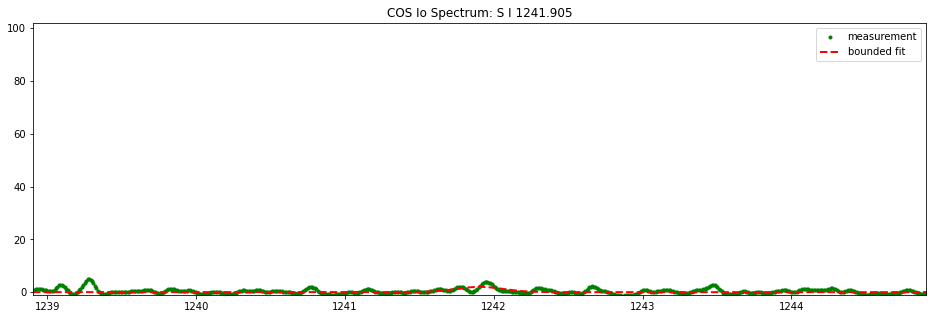

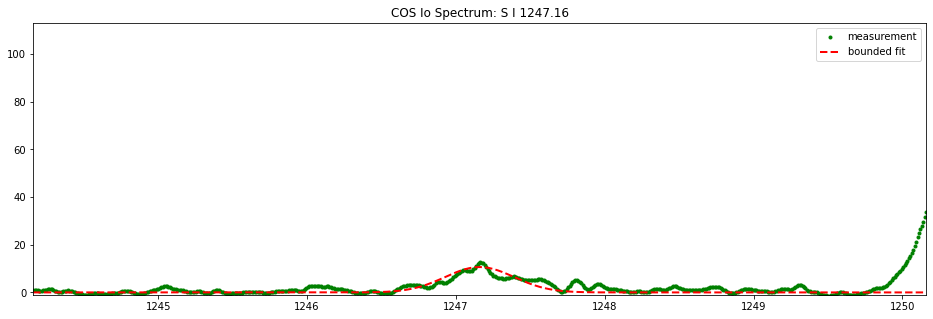

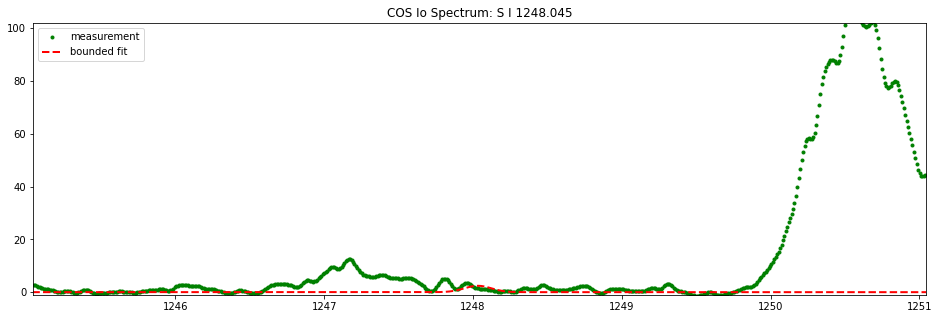

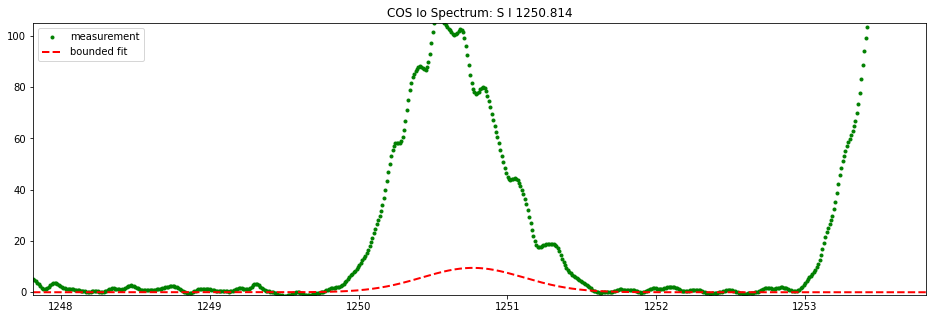

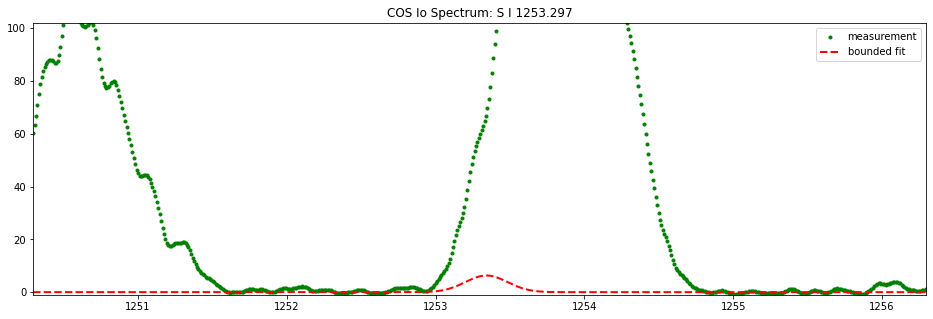

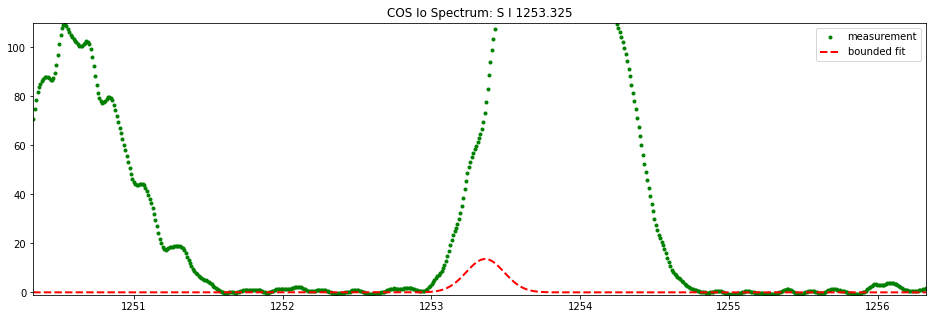

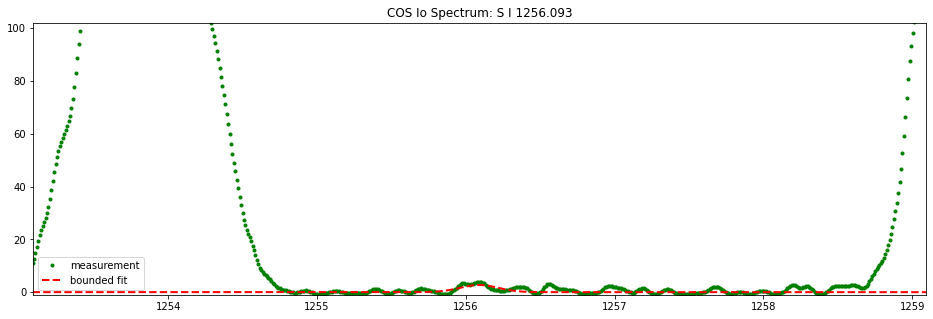

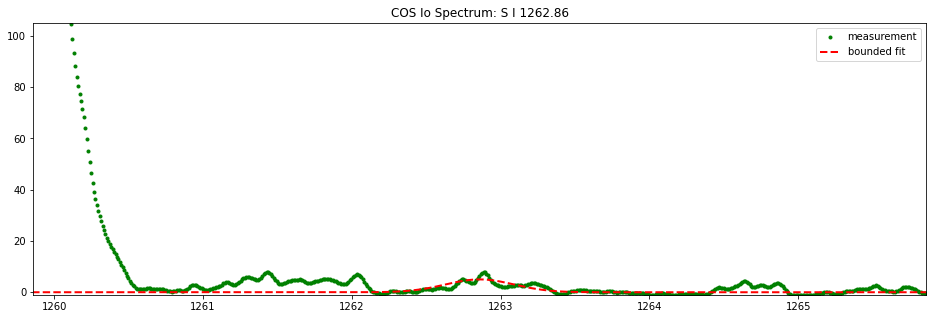

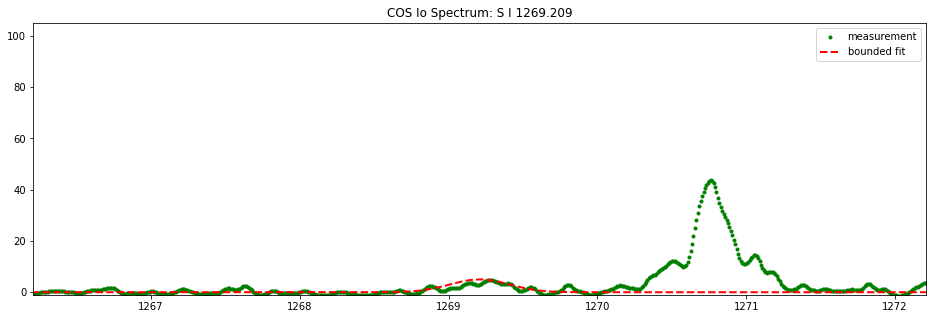

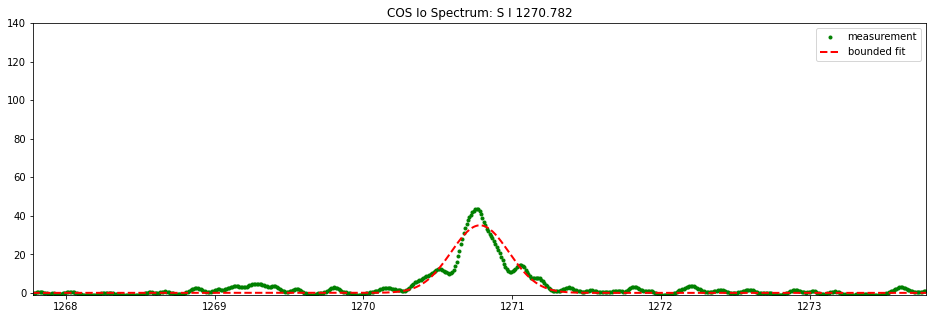

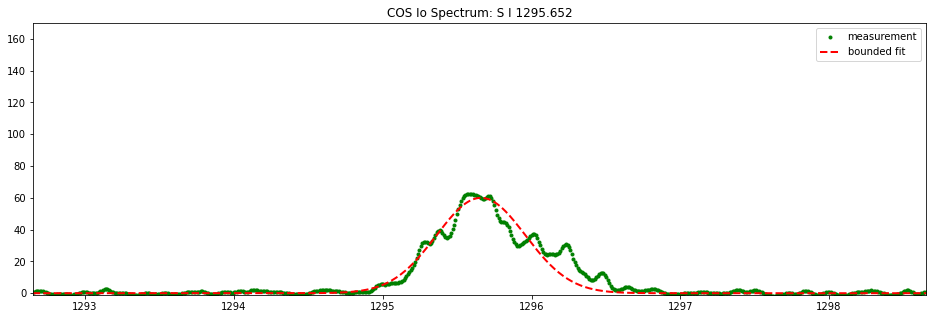

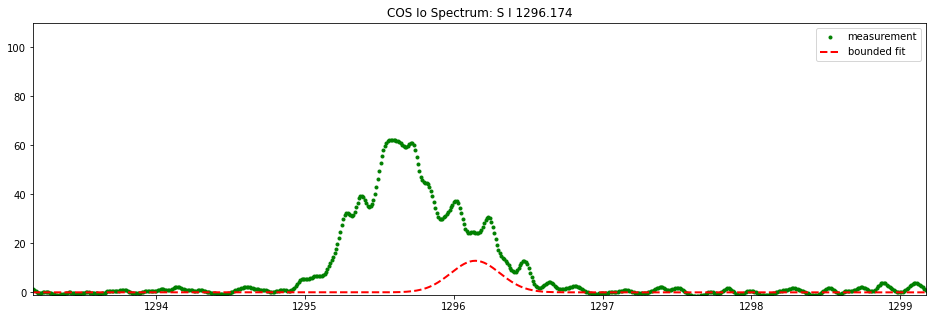

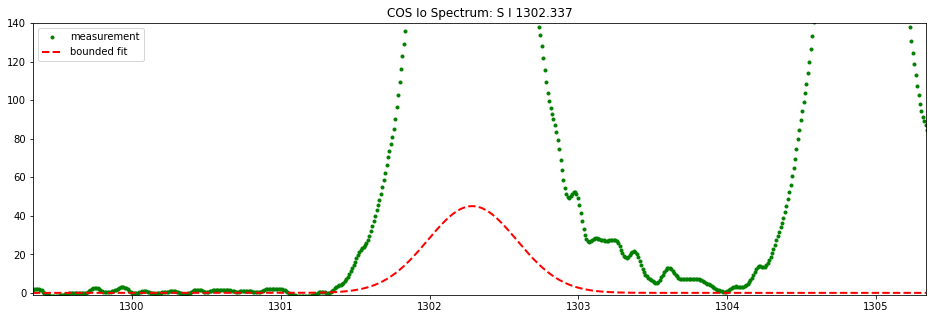

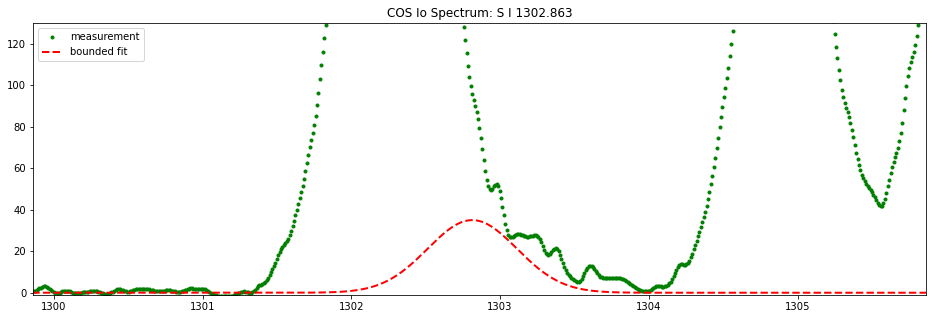

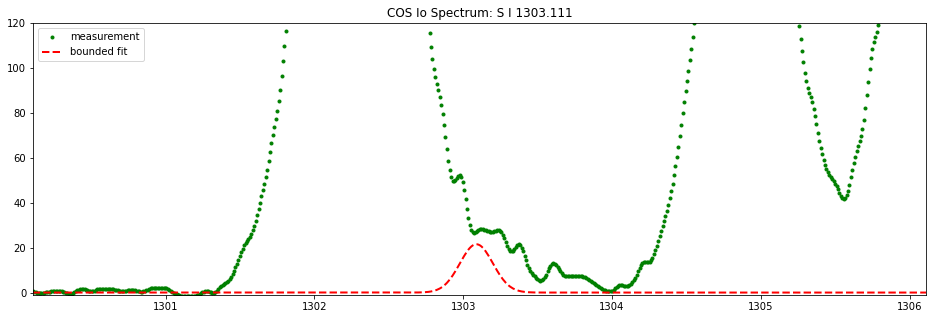

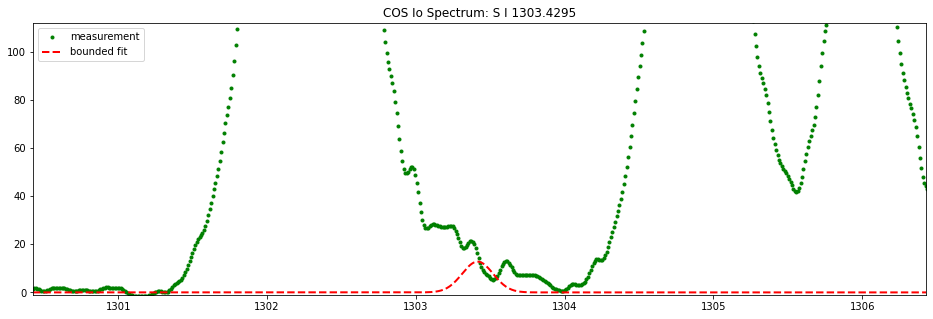

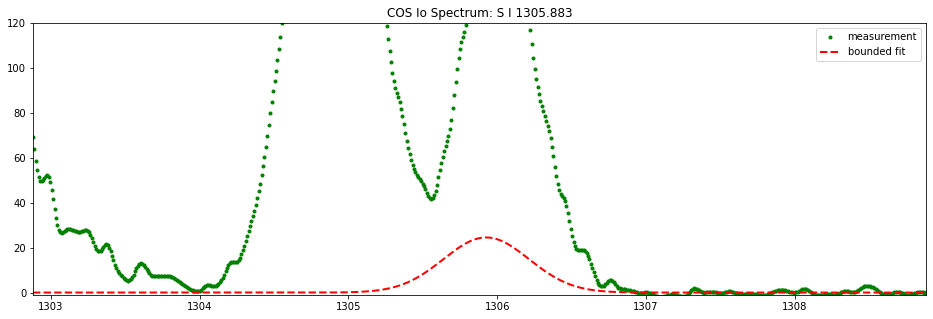

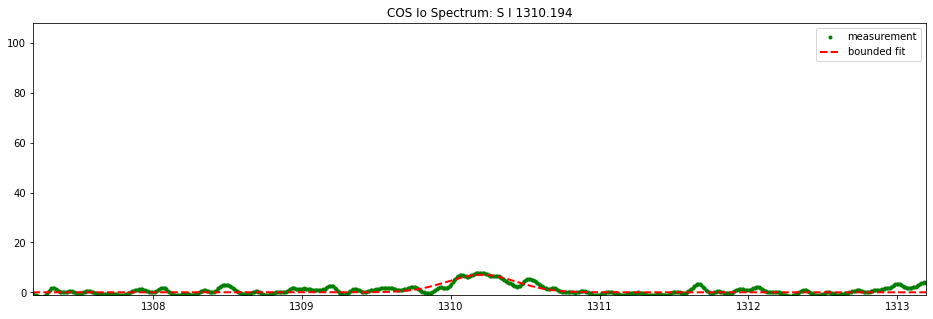

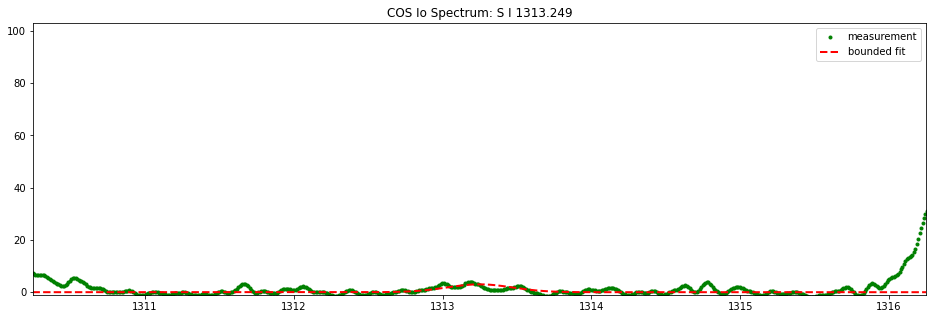

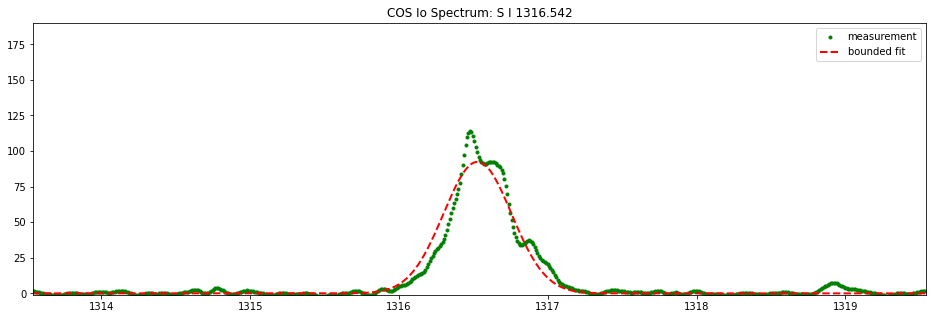

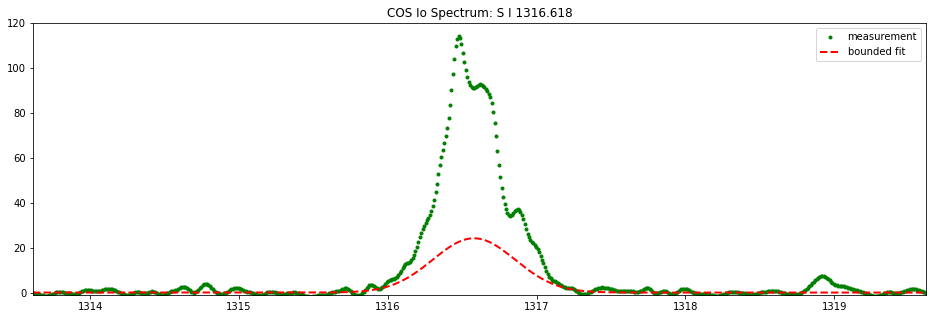

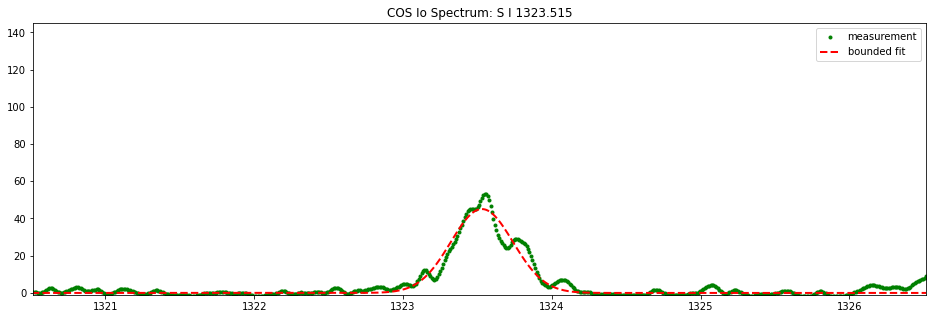

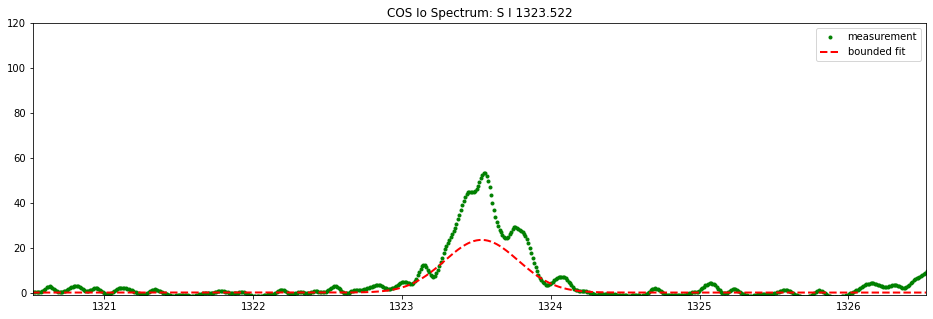

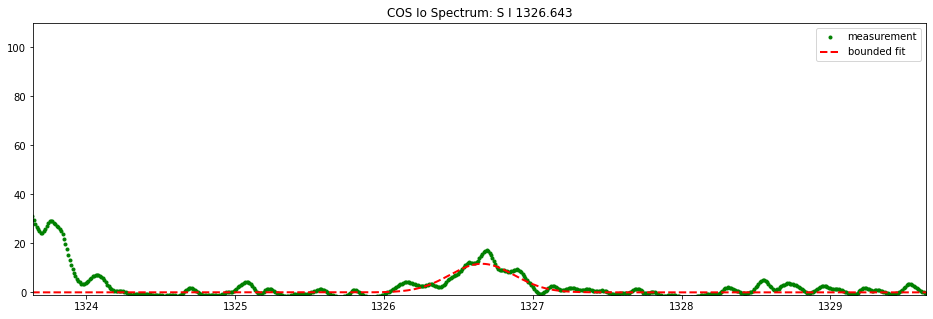

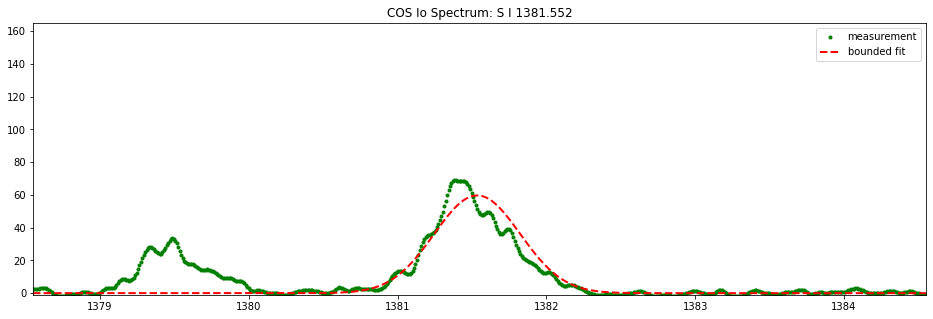

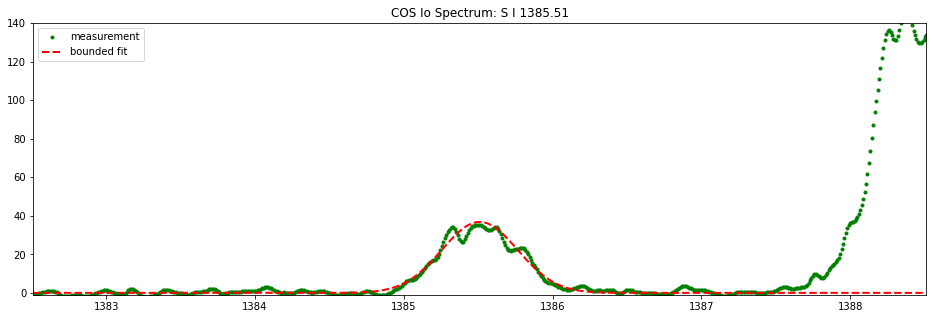

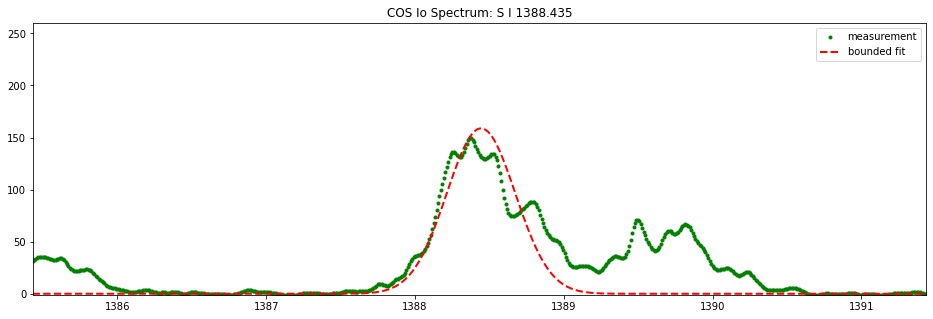

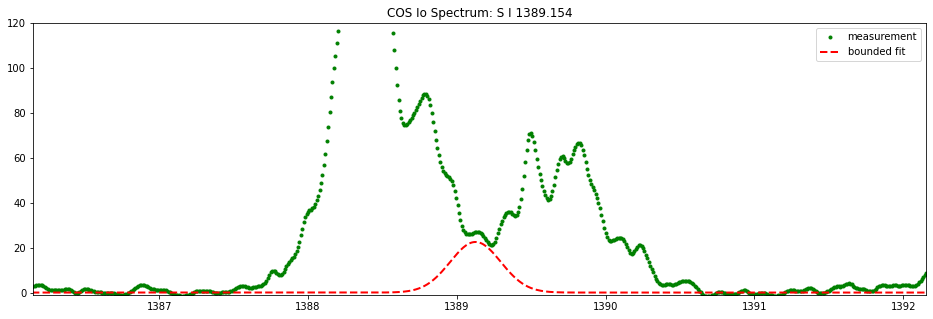

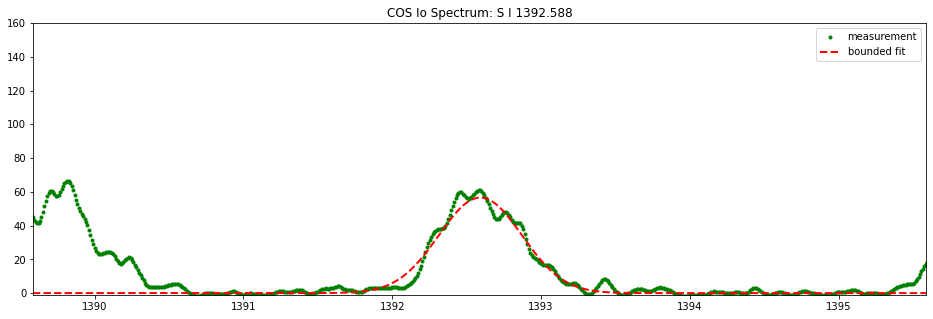

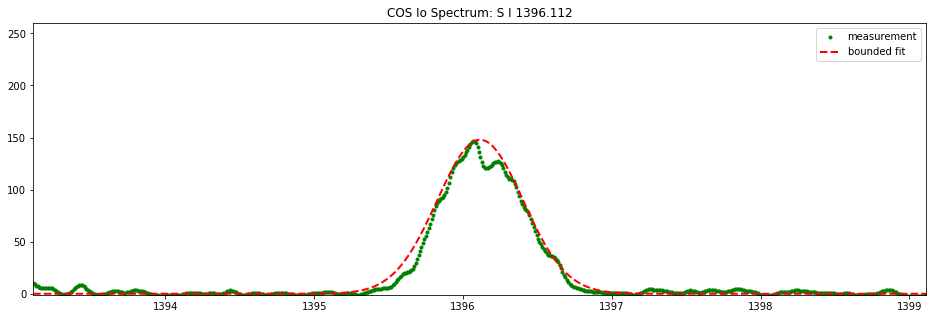

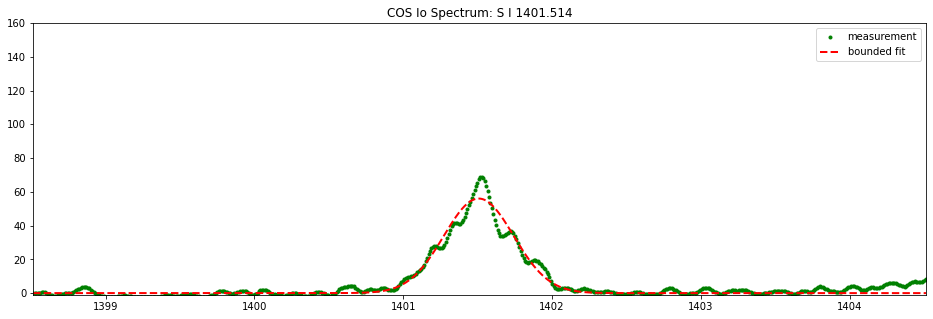

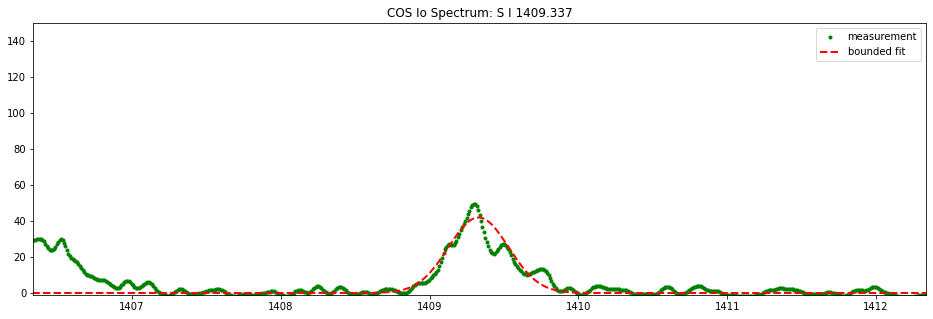

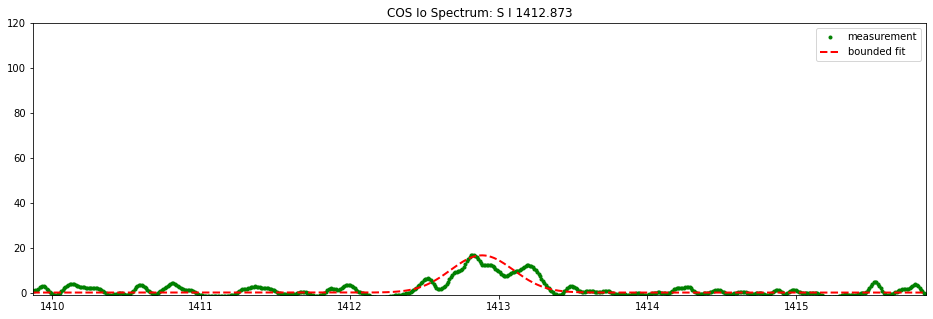

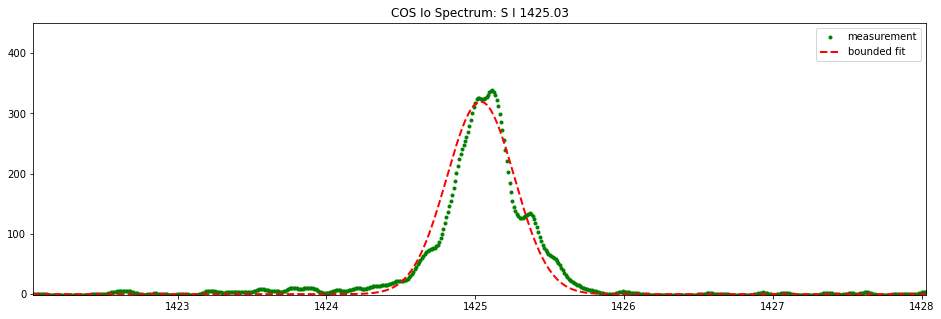

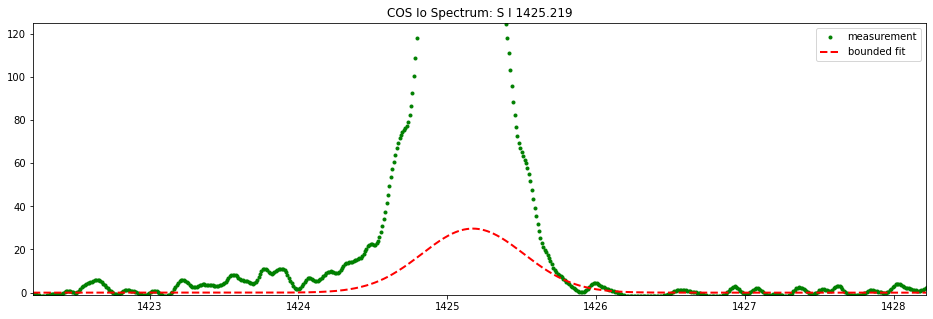

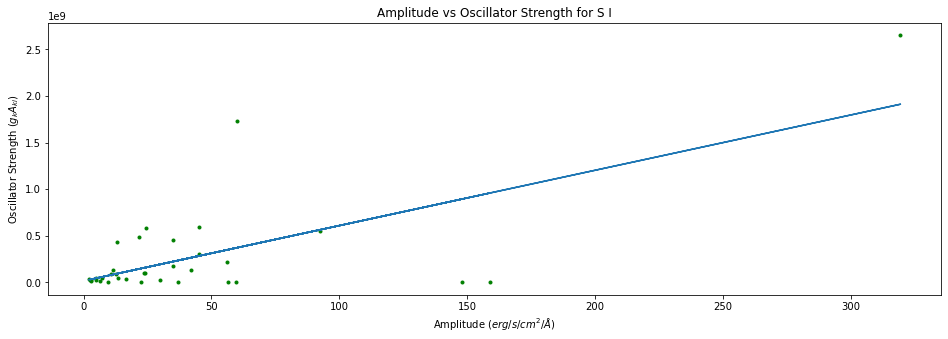

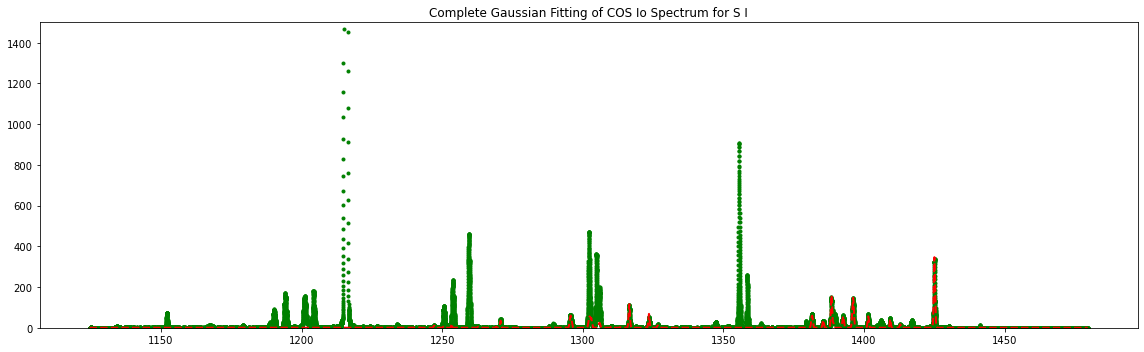

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


<Figure size 432x288 with 0 Axes>

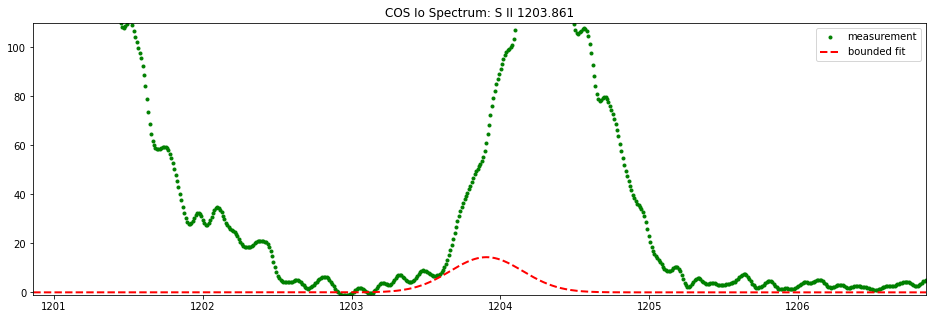

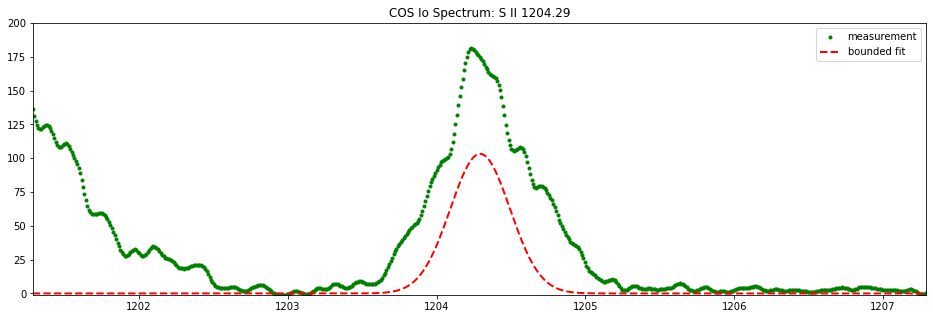

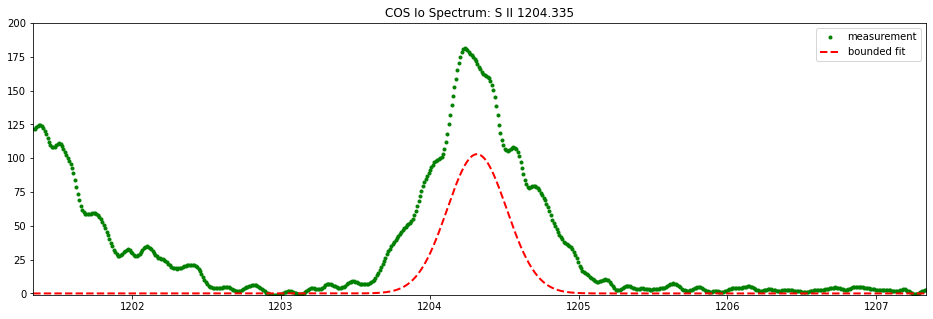

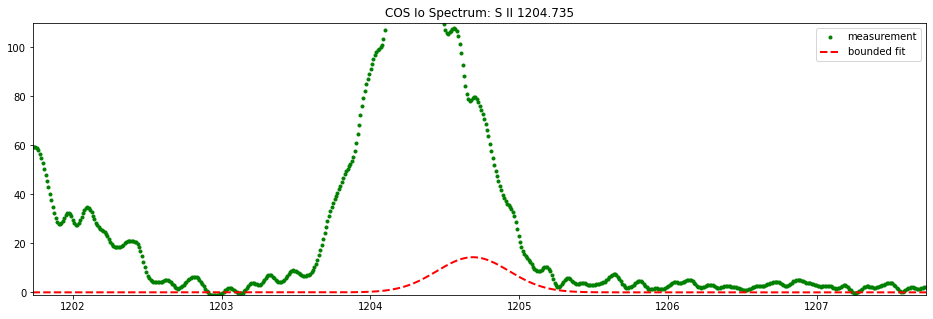

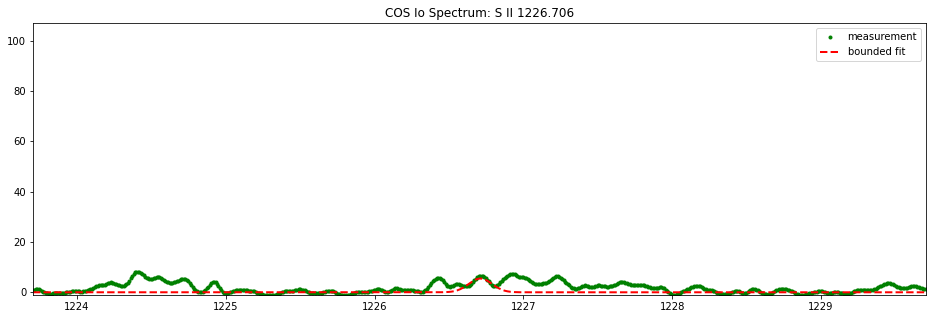

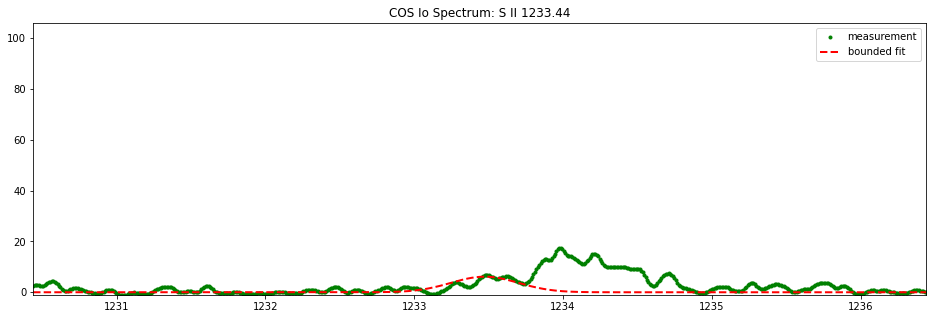

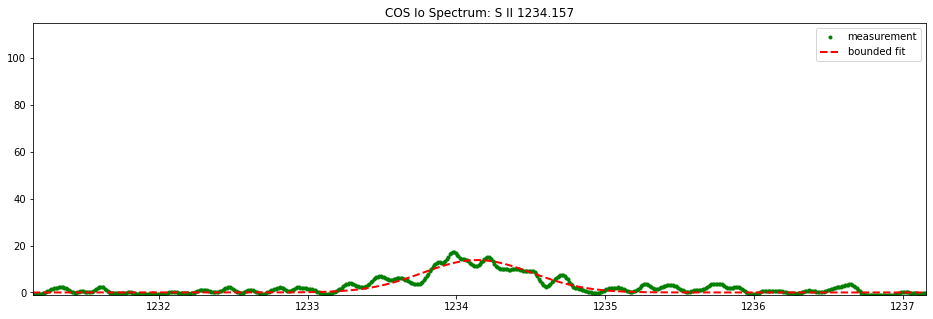

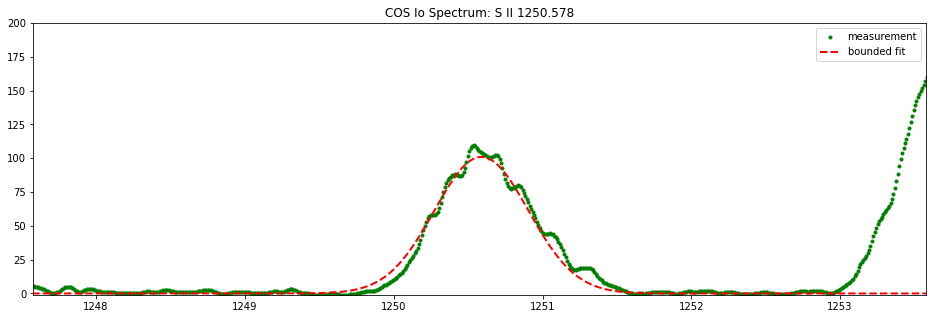

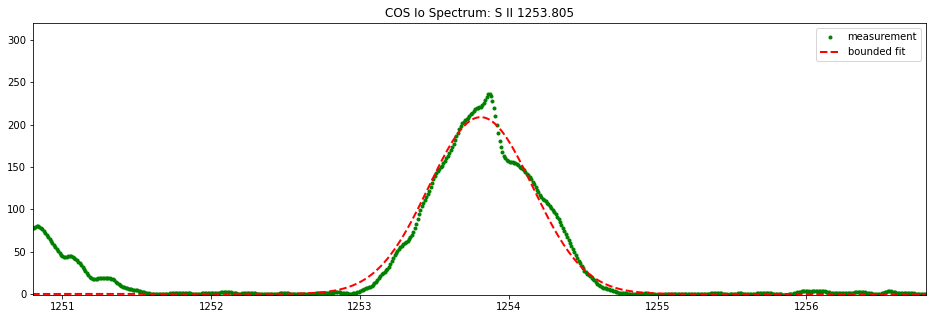

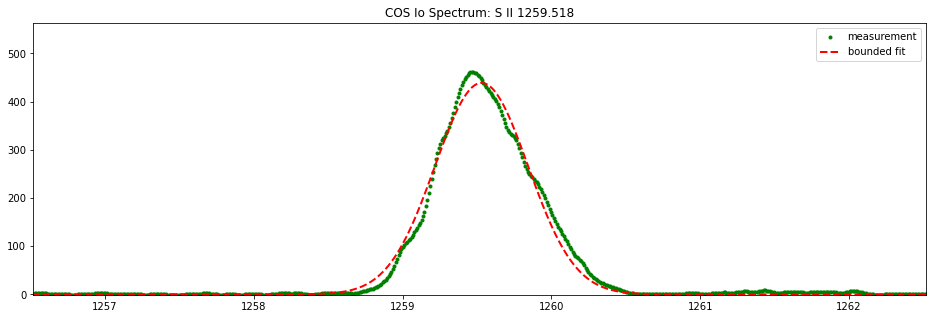

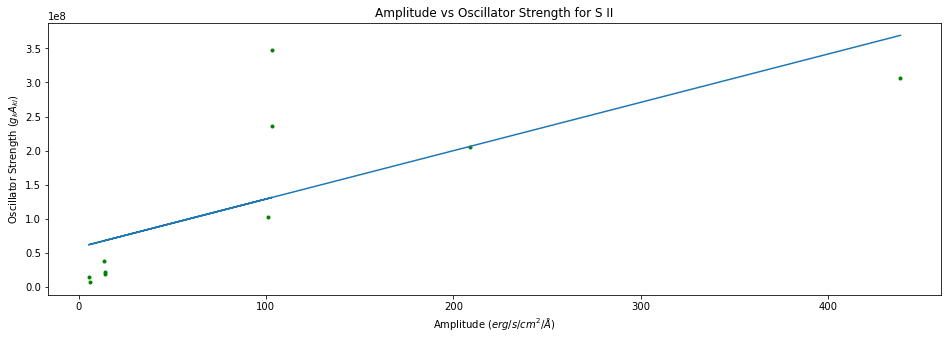

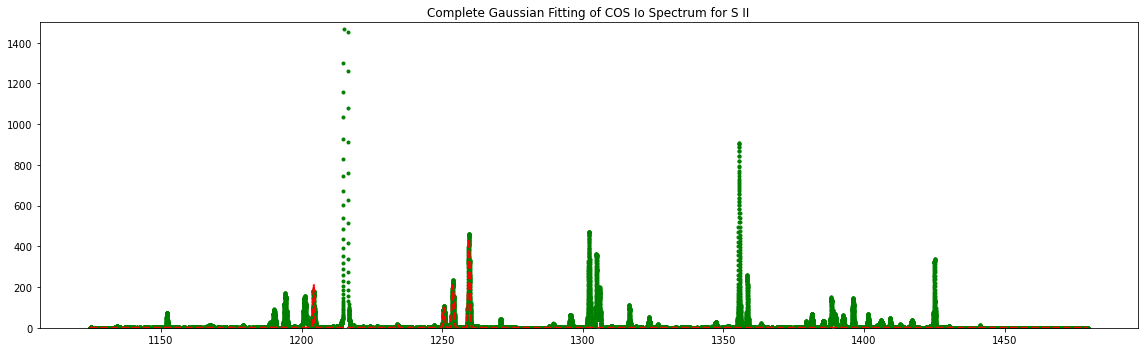

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.47it/s]


<Figure size 432x288 with 0 Axes>

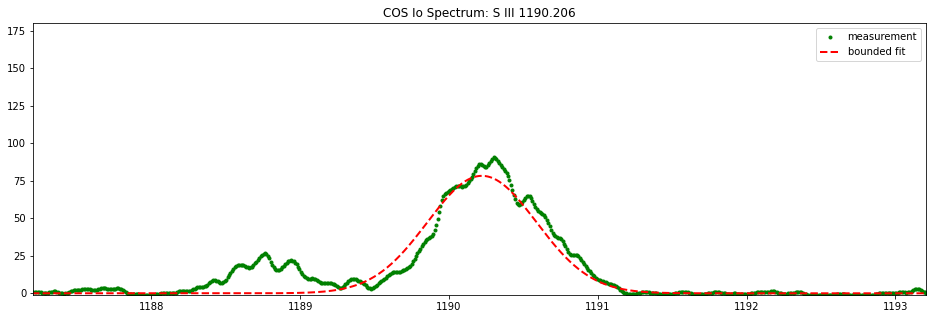

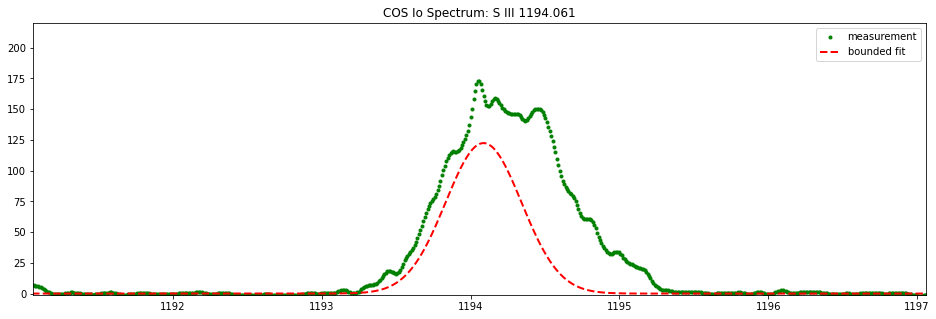

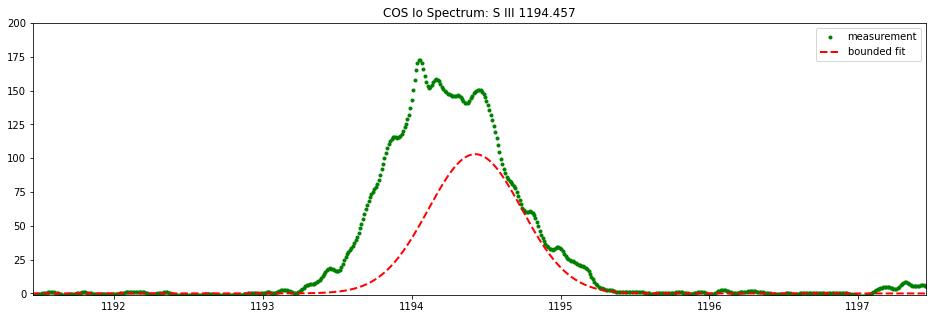

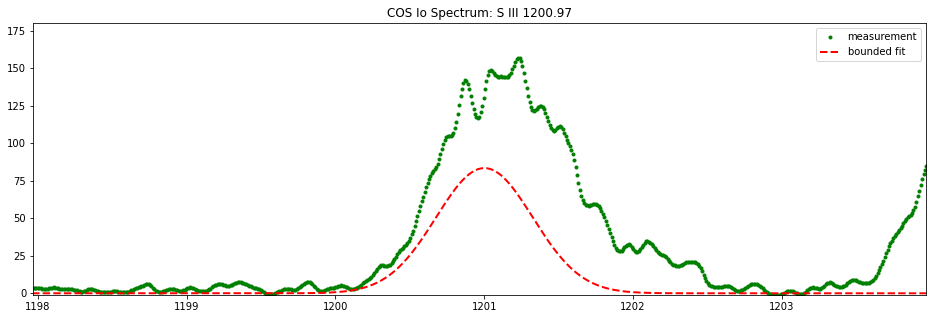

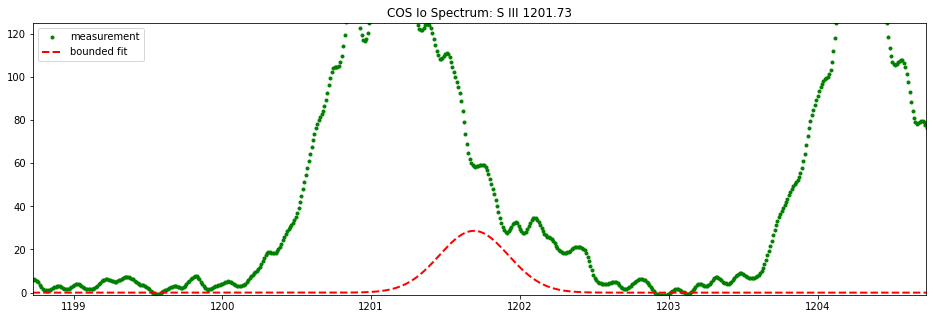

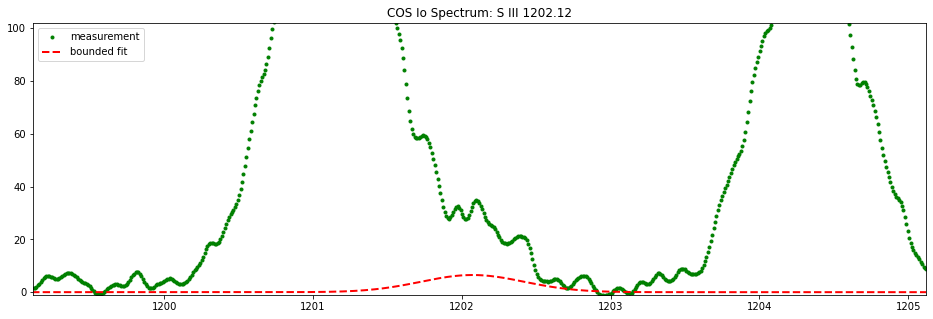

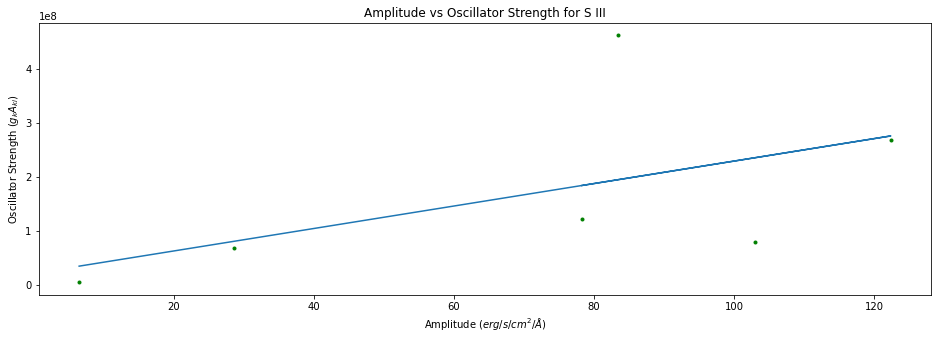

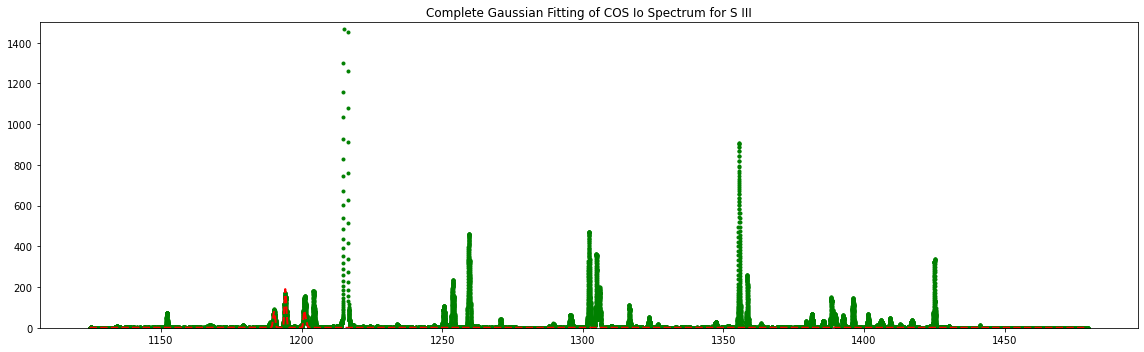

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.79it/s]


<Figure size 432x288 with 0 Axes>

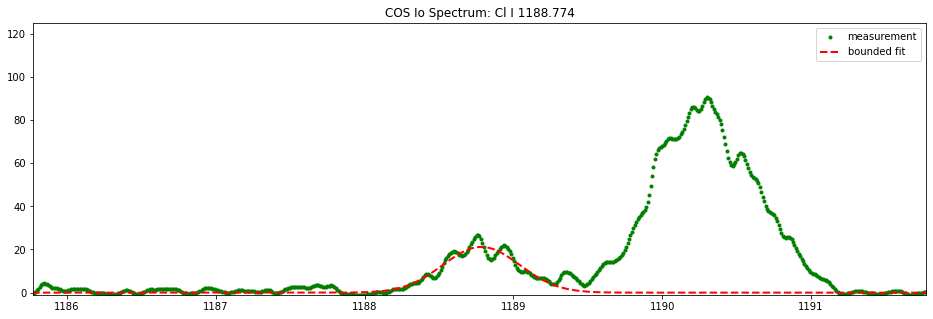

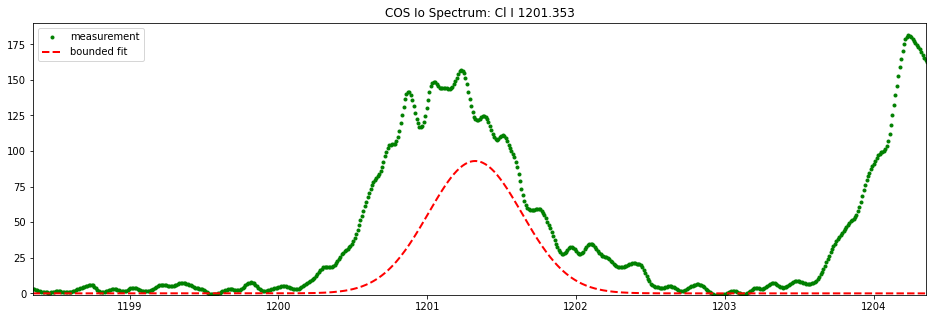

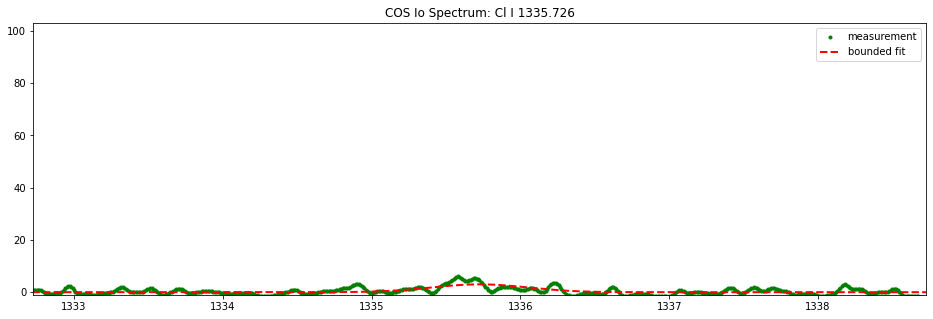

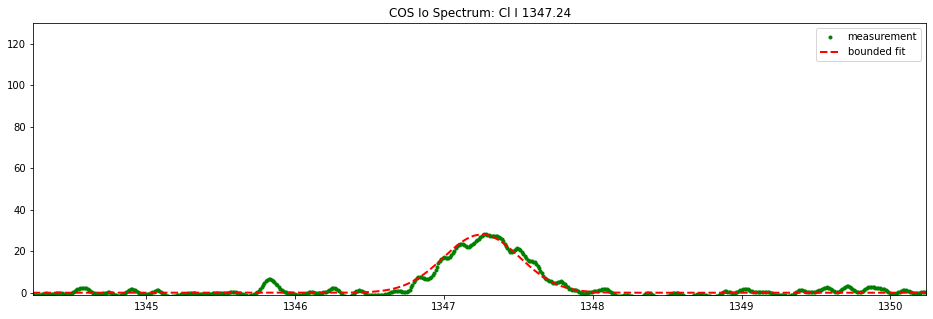

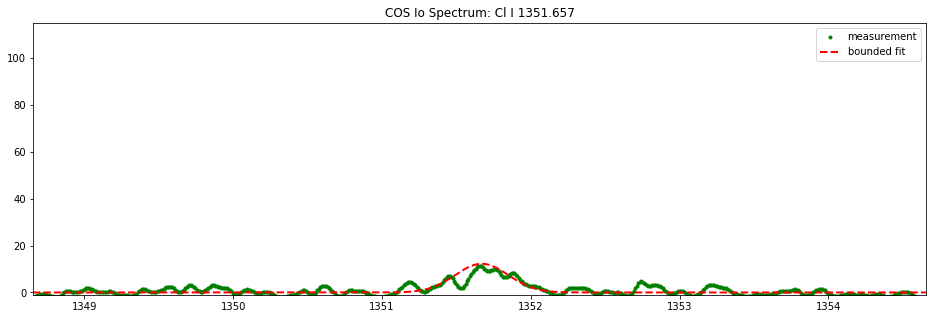

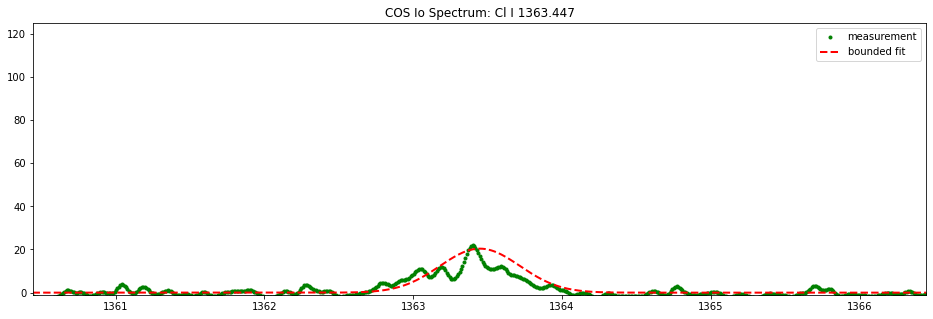

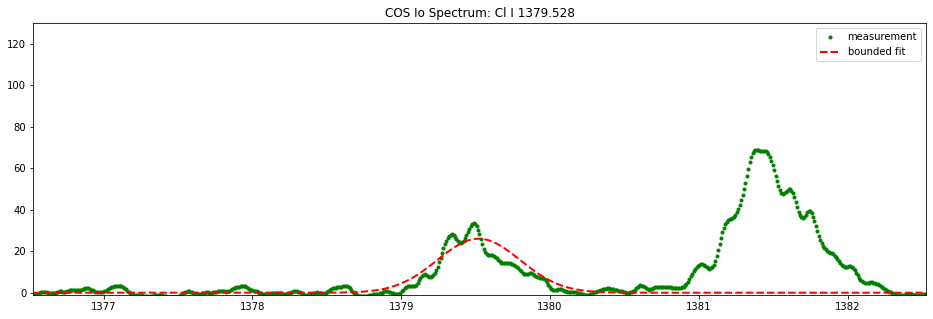

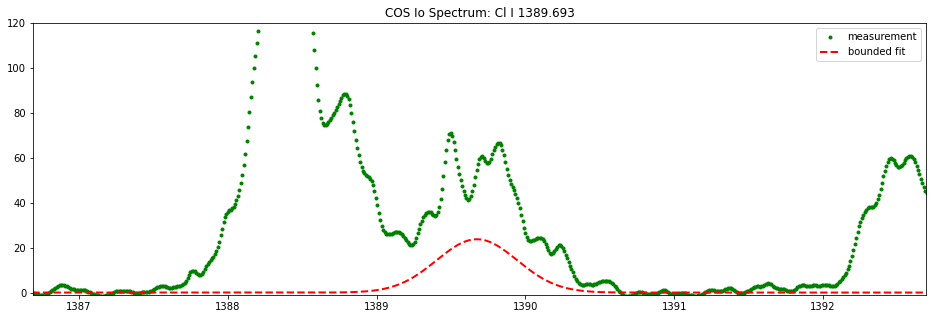

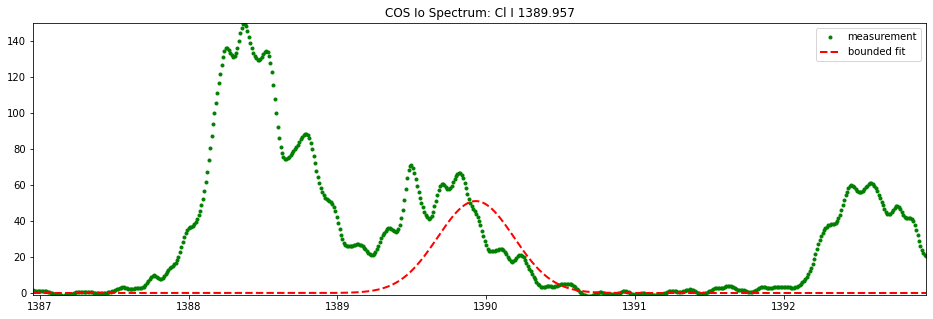

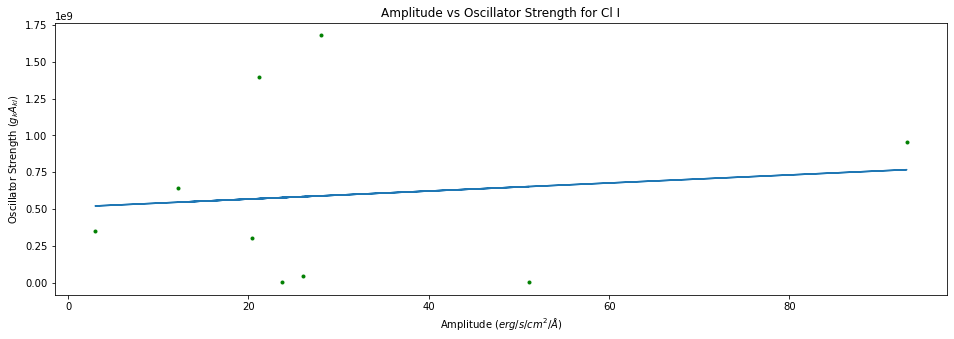

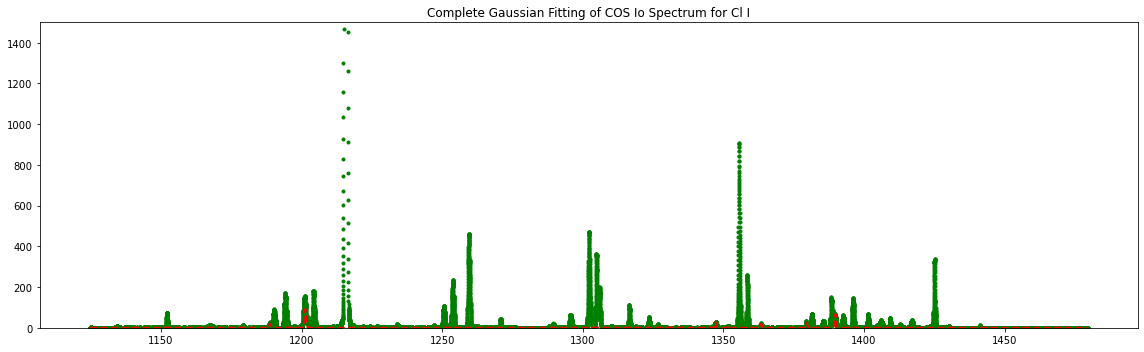

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.79it/s]


<Figure size 432x288 with 0 Axes>

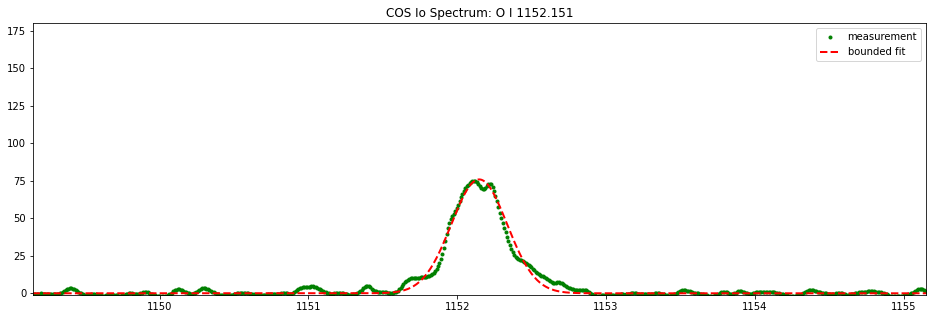

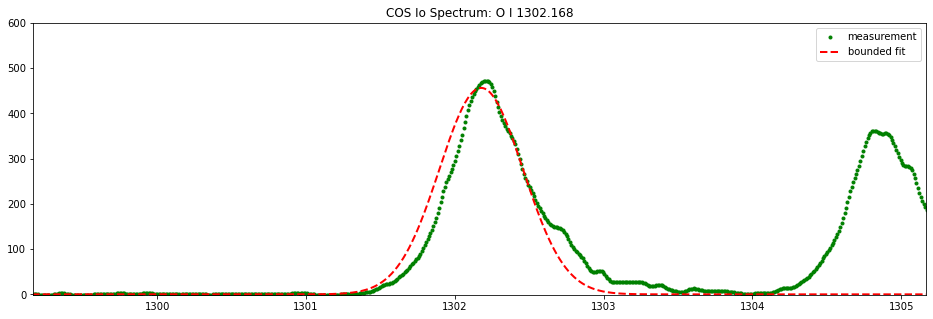

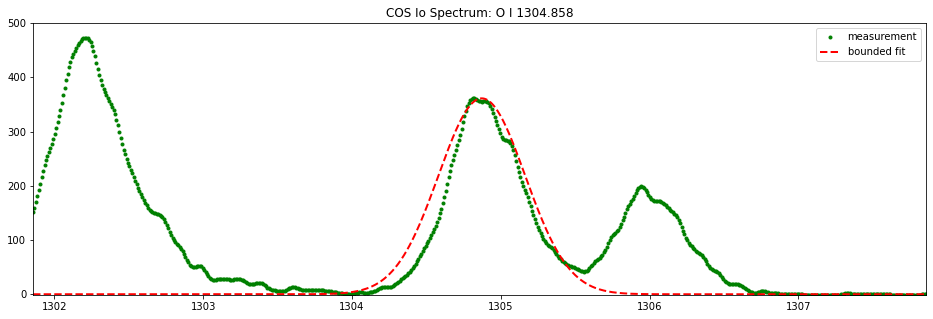

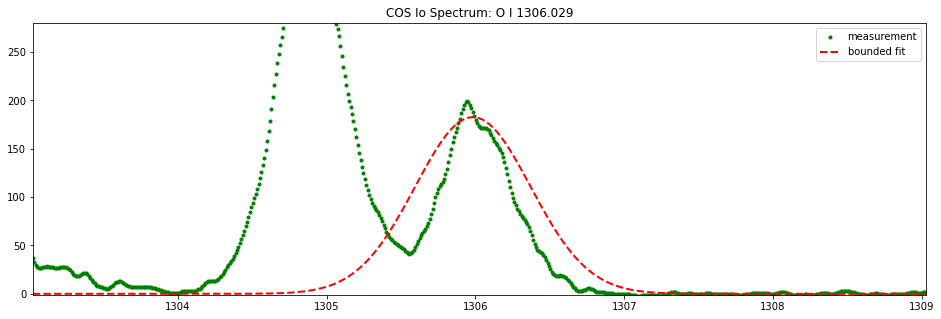

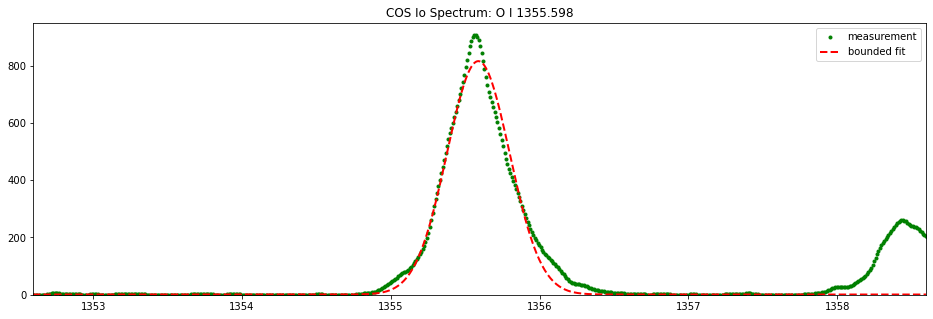

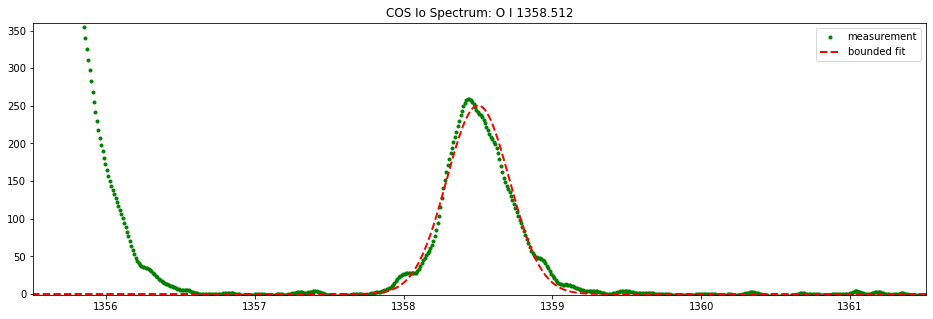

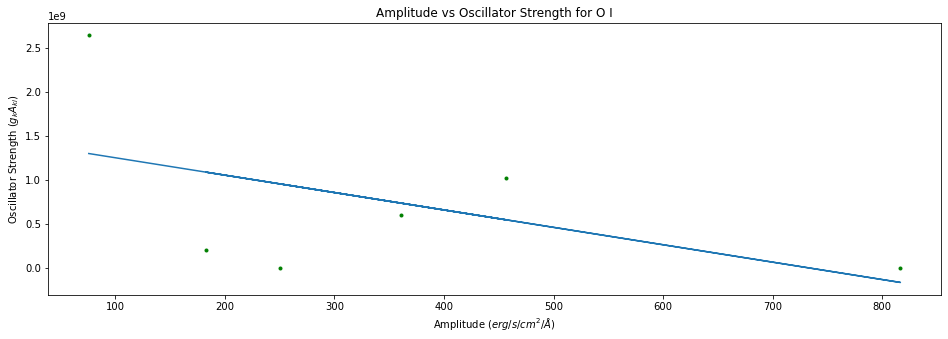

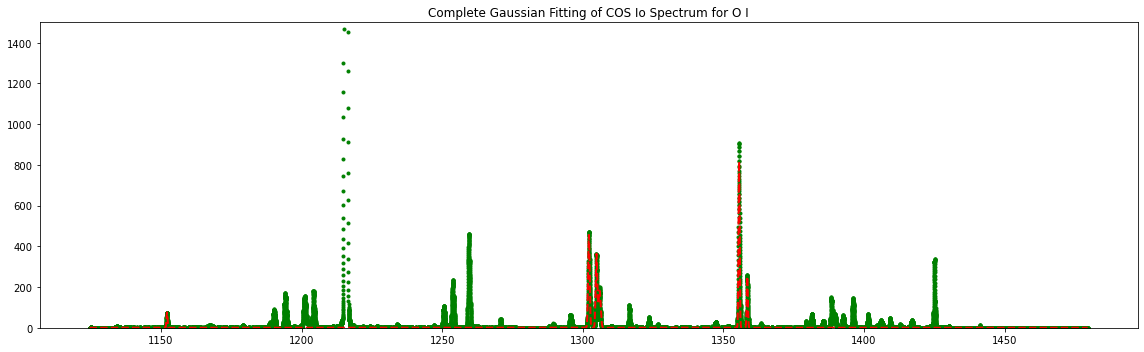

<Figure size 432x288 with 0 Axes>

In [155]:
%matplotlib inline
#plots fit of all individual lines by species, total Gaussian fit per species, and oscillator strength vs amplitude plot
for i in range(0,len(lines)):
    line = lines[i]
    test,array_line = target_array(line)
    params = fit_whole_spectra(test)
    species_plot(line)
    full_plot_per_species()
    total_params = np.vstack((total_params,params))
    a = (len(params))
    length.append(a)

<IPython.core.display.Javascript object>


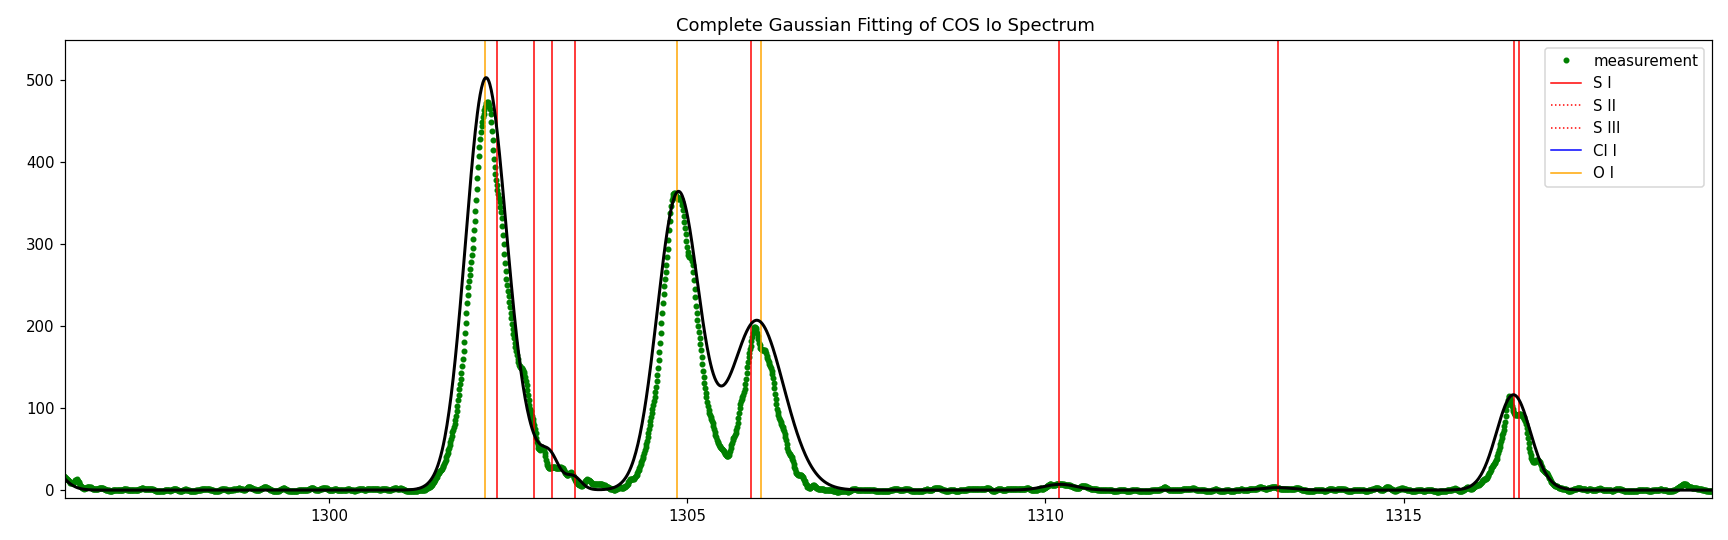

In [170]:
%matplotlib notebook
#plots total Gaussian fitting of spectra
import matplotlib.pyplot as plt
total_spectrum_plot(total_params, c='black')
plt.show()
save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'

<IPython.core.display.Javascript object>


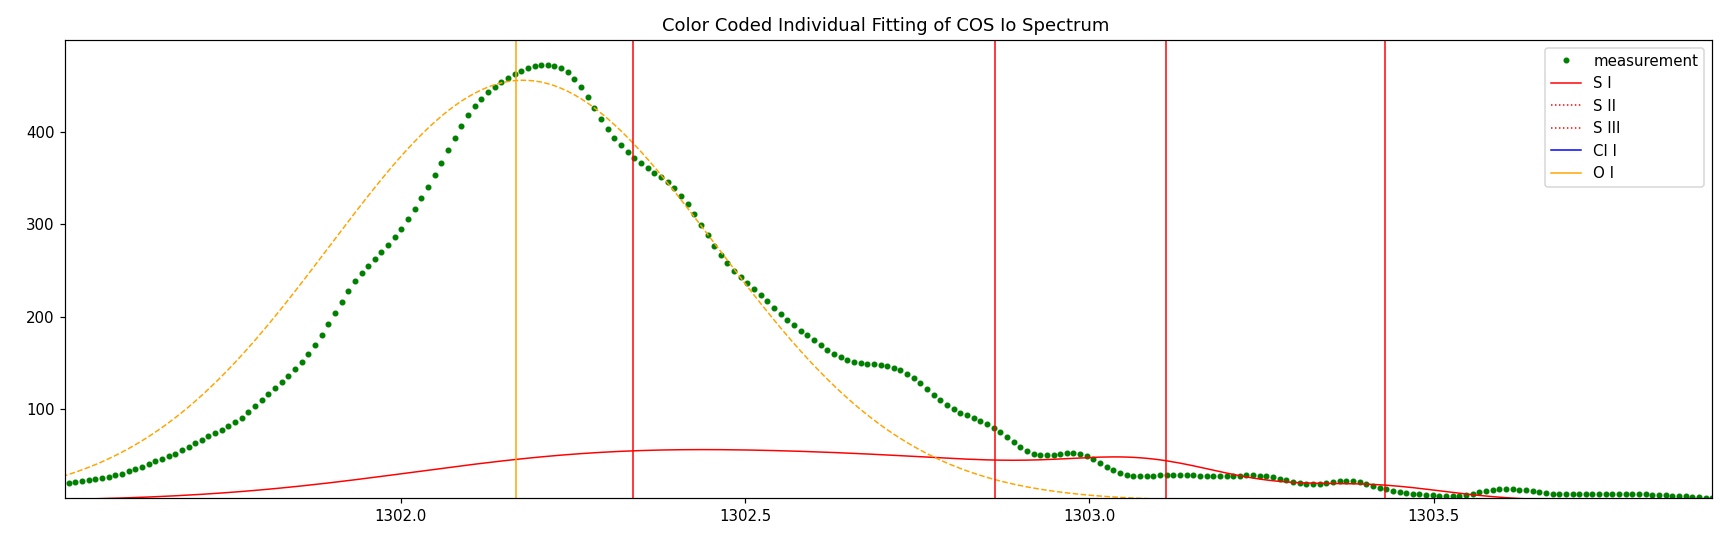

In [171]:
#plots total Gaussian fitting per species
df_wavelength = array['Wavelength']
color_change(total_params)

In [158]:
b = brightness(total_params) #if numpy.array error pops up run the functions cell again

<IPython.core.display.Javascript object>


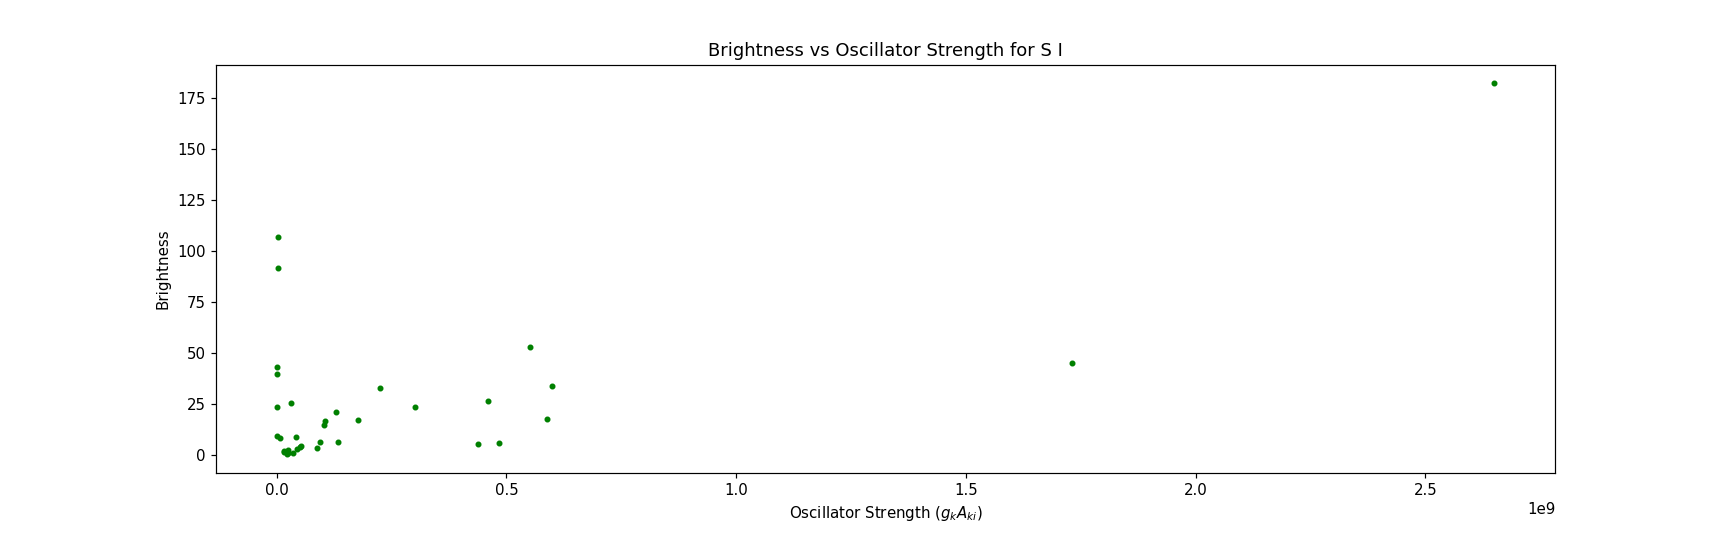

<IPython.core.display.Javascript object>


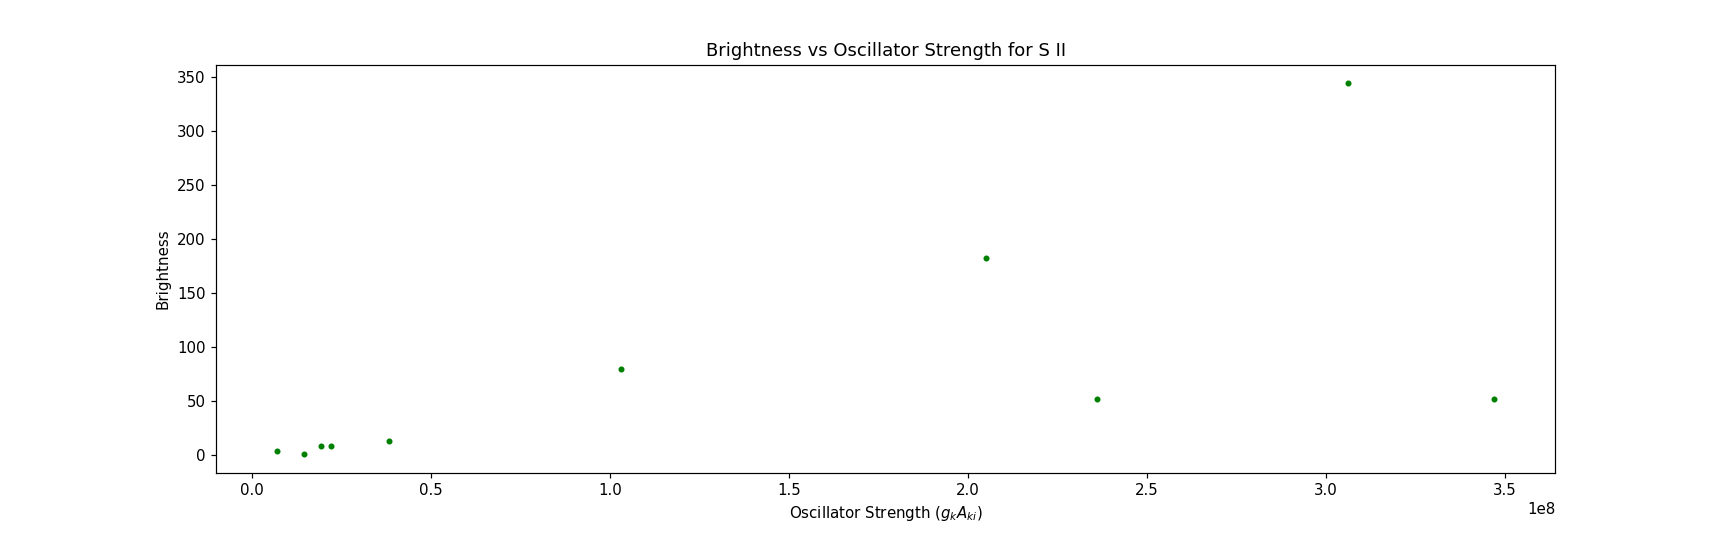

<IPython.core.display.Javascript object>


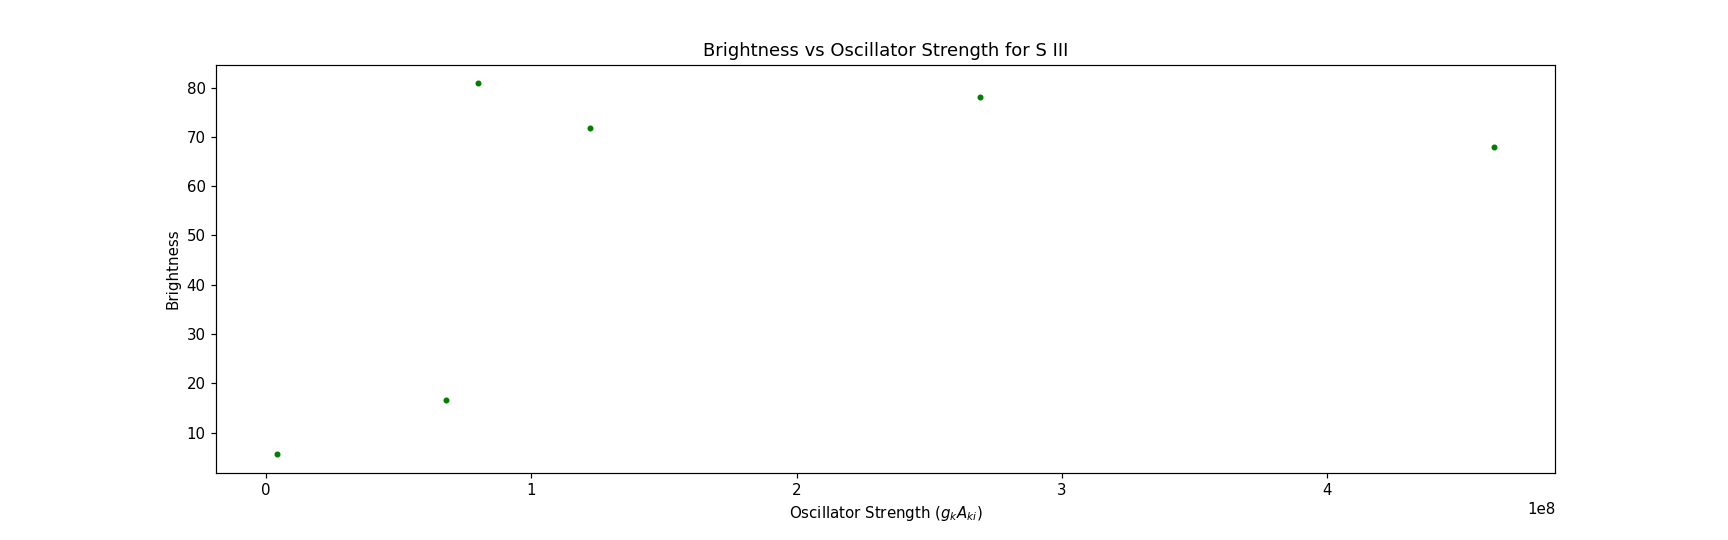

<IPython.core.display.Javascript object>


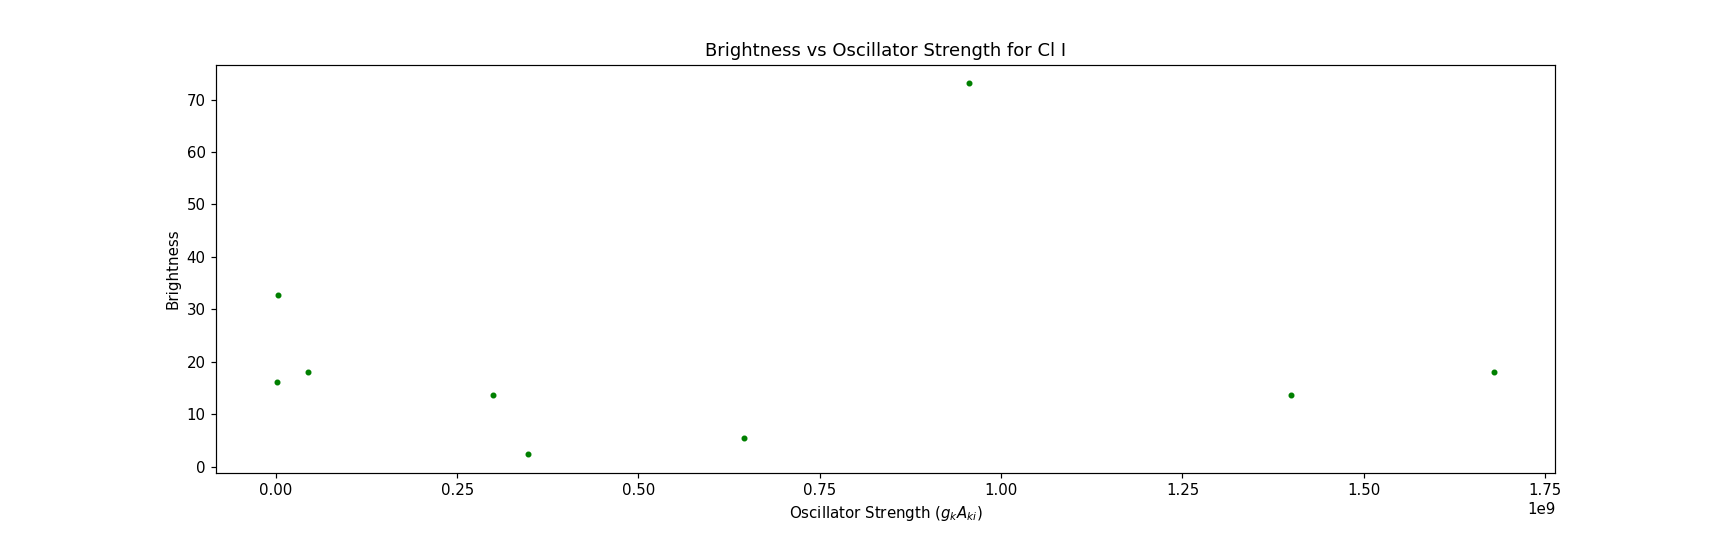

<IPython.core.display.Javascript object>


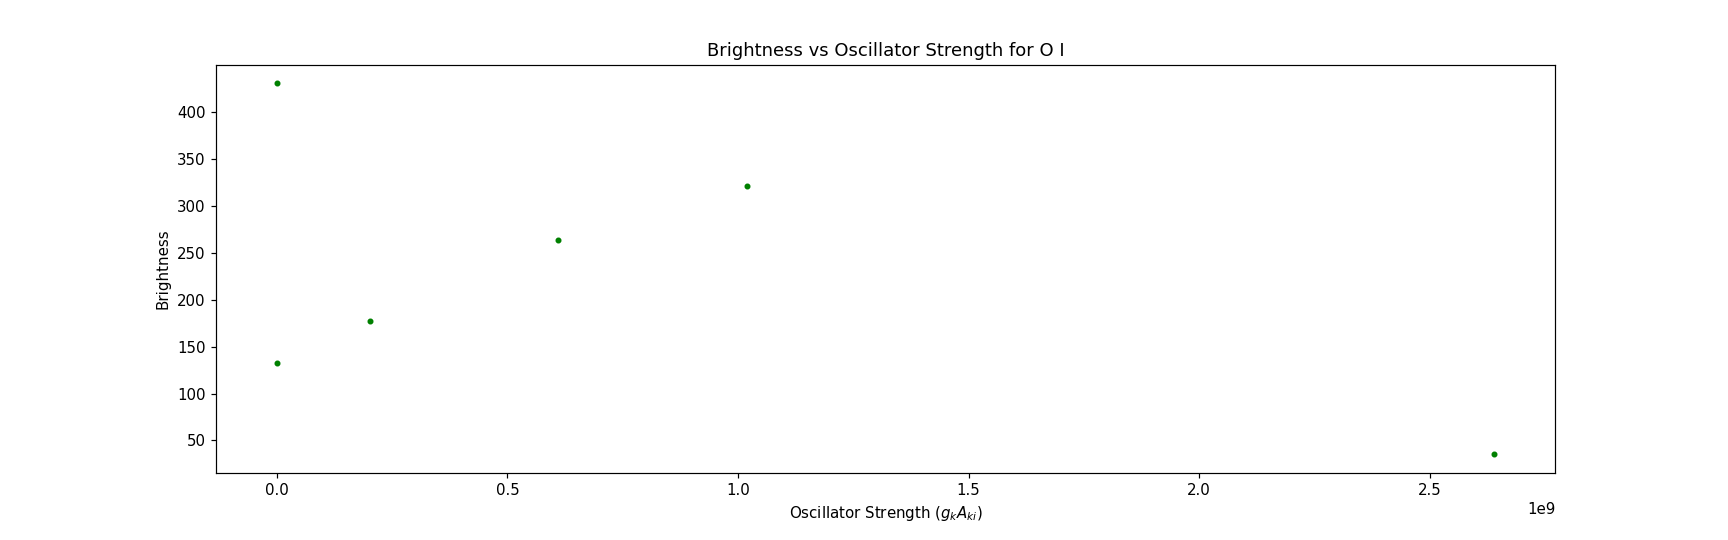

In [159]:
%matplotlib notebook
for i in range(0,len(lines)):
    line = lines[i]
    brightness = b[i]
    test,array_line = target_array(line)
    no_nans = array_line.dropna() #remove lines that do not have an oscillator strength
    os = no_nans['Oscillator Strength (gA)']
    os_vs_brightness(os,brightness)

In [160]:
df = pd.DataFrame()
for i in range(0,len(lines)):
    df.round(3) #set decimal place for all columns
    line = lines[i]
    test,array_line = target_array(line)
    brightness = b[i]
    df_pull = pd.DataFrame(test, columns = ['Wavelength','Sigma','Amplitude'])
    df_brightness = pd.DataFrame(brightness, columns = ['Brightness'])
    df_pull['Brightness'] = df_brightness  
    no_nans = array_line.dropna()
    os = no_nans['Oscillator Strength (gA)']
    os = os.tolist()
    #pd.set_option('display.float_format', '{:.4E}'.format)
    df_os = pd.DataFrame(os, columns = ['Oscillator Strength (gA)'])
    df_pull['Oscillator Strength (gA)'] = df_os
    df = df.append(df_pull)

In [161]:
#this cell is used to remove duplicated indicies from the dataframe by converting it back to an array
#and then creating a new dataframe
fake = df.to_numpy()
fake = pd.DataFrame(fake, columns = ['Wavelength','Sigma','Amplitude','Brightness','Oscillator Strength (gA)'])

In [162]:
#sectioning the complete dataframe for the whole spectra into each species
df_s1 = fake.iloc[0:length[1]]
df_s2 = fake.iloc[length[1]:length[1]+length[2]]
df_s3 = fake.iloc[length[1]+length[2]:length[1]+length[2]+length[3]]
df_cl1 = fake.iloc[length[1]+length[2]+length[3]:length[1]+length[2]+length[3]+length[4]]
df_o1 = fake.iloc[length[1]+length[2]+length[3]+length[4]:length[1]+length[2]+length[3]+length[4]+length[5]]

Now we will take a look at Cl I and see if the ratio of the oscillator strength for lines with the same upper bound is the same as the ratio of the brightness. If the ratios are completely mismatches, this proves that chlorine is optically thick and is self-absorbing.

In [163]:
df_cl1

,Wavelength,Sigma,Amplitude,Brightness,Oscillator Strength (gA)
51,1188.774,0.21,25.0,13.686389,1400000000.0
52,1201.353,0.25,90.0,73.093317,956000000.0
53,1335.726,0.32,3.0,2.406363,348000000.0
54,1347.24,0.26,30.0,18.029902,1680000000.0
55,1351.657,0.2,15.0,5.482162,646000000.0
56,1363.447,0.3,25.0,13.730731,300000000.0
57,1379.528,0.3,30.0,18.104168,44000000.0
58,1389.693,0.2,20.0,16.0896,1400000.0
59,1389.957,0.2,50.0,32.798011,3400000.0


From NIST, we can see that lines 1347.240 and 1363.447 have the same upper energy state at $3s^23p^4(^3P)4s$. Thus we can look at the ratio of the oscillator strengths, giving us $\frac{1.68*10^9}{3.00*10^8}=5.6$. Thus, 1347.240 should have a brightness that is approximately 5.6 times brighter than 1363.447. However, when we calculate the ratio for brightness, we get $\frac{17.73}{13.74}=1.29$, meaning that the first line is only 1.29 times brighter than the second line. We can verify that our work is correct by doing the same calculation for the brightest lines, O I 1355.598 and O I 1358.512.

In [168]:
df_o1

,Wavelength,Sigma,Amplitude,Brightness,Oscillator Strength (gA)
60,1152.151,0.2,80.0,35.648225,2640000000.0
61,1302.168,0.3,500.0,321.021453,1020000000.0
62,1304.858,0.3,400.0,263.534028,609000000.0
63,1306.029,0.3,180.0,177.601147,203000000.0
64,1355.598,0.21,850.0,430.173133,21000.0
65,1358.512,0.21,260.0,132.383405,6800.0


The oscillator strength ratio is $\frac{2.1*10^4}{6.8*10^3}=3.09$. The brightness ratio is $\frac{4.19*10^2}{1.31*10^2}=3.20$. This is a 0.11 difference which means the fit has a 0.04 or 4% error.

Thus, we can conclude that the fitting is accurate, so the chlorine in Io's atmosphere cannot be recorded over time because the changes in chlorine are affected due to self absorbance. It is a degenerate case.

In [169]:
df_s1

,Wavelength,Sigma,Amplitude,Brightness,Oscillator Strength (gA)
0,1241.905,0.16,2.0,0.802121,36600000.0
1,1247.16,0.2,13.0,6.173789,95200000.0
2,1248.045,0.06,2.0,0.548914,22600000.0
3,1250.814,0.25,5.0,8.136264,7980000.0
4,1253.297,0.05,2.0,2.236187,15900000.0
5,1253.325,0.05,10.0,4.335628,53500000.0
6,1256.093,0.1,2.0,0.872999,23900000.0
7,1262.86,0.23,5.0,2.882623,44400000.0
8,1269.209,0.2,5.0,2.506628,24500000.0
9,1270.782,0.22,40.0,16.971741,178000000.0


In [166]:
df_s2

,Wavelength,Sigma,Amplitude,Brightness,Oscillator Strength (gA)
35,1203.861,0.15,10.0,8.753238,22100000.0
36,1204.29,0.15,100.0,51.848068,236000000.0
37,1204.335,0.15,100.0,51.548066,347000000.0
38,1204.735,0.15,10.0,8.719378,19200000.0
39,1226.706,0.05,7.0,1.074826,14600000.0
40,1233.44,0.15,6.0,3.468442,6960000.0
41,1234.157,0.37,15.0,12.712209,38200000.0
42,1250.578,0.3,100.0,80.074121,103000000.0
43,1253.805,0.35,220.0,182.635393,205000000.0
44,1259.518,0.31,463.0,344.128753,306000000.0


In [167]:
df_s3

,Wavelength,Sigma,Amplitude,Brightness,Oscillator Strength (gA)
45,1190.206,0.4,80.0,71.717859,122000000.0
46,1194.061,0.2,120.0,78.164158,269000000.0
47,1194.457,0.25,100.0,80.881974,79800000.0
48,1200.97,0.26,80.0,67.886013,463000000.0
49,1201.73,0.15,25.0,16.607173,68000000.0
50,1202.12,0.25,2.0,5.655908,4080000.0
